# AceleraDev Data Science Project - Recommender System to Generate Leads based on Clients' Portfolio
___

## <a name="top">Table of Contents</a>
1. [Introduction](#introduction)  
    1.1 [Objective](#objective)  
    1.2 [Technical Requirements](#requirements)  
    1.3 [Defining the Process](#defprocess)  
    1.4 [The Dataset](#dataset)  
    1.5 [Packages imports](#imports)  
2. [Exploratory Data Analysis](#exploratory)  
    2.1 [Load Market Data](#loaddata)  
    2.2 [Describing Market Database](#marketdatabase)  
    2.3 [Defining Missing Values Threshold](#missing1)  
    2.4 [Identifying ID and Constant Features](#crapfeatures1)  
    2.5 [Verifying Features' Types](#types)  
    2.5.1 [Float Features](#floatfeat)  
    2.5.2 [Integer Features](#intfeat)  
    2.5.3 [Categorical Features](#catfeat)  
    2.6 [Imputing Missing Values](#missing2)  
    2.6.1 [Missing Values of Numeric Features](#missingnum)  
    2.6.2 [Missing Values of Categorical Features](#missingcat)  
    2.7 [Feature Selection](#featuresel)  
3. [Algorithm Evaluation and Overview of the Steps to be Taken](#overview)  
    3.1 [Types of Recommender Systems](#typesrecsys)  
    3.2 [Selected Approach and Steps](#approach)  
4. [Model Training](#training)  
    4.1 [Load Portfolio Data](#portfoliodata)  
    4.2 ["Companies Profile" Table / Principal Components DataFrame](#pc)  
    4.3 [Clustering Companies with MiniBatchKMeans](#cluster)  
    4.4 [Functions to Create Rating table and to Train Logistic Regression by Cluster](#importantfunctions)  
    4.5 [Logistic Regression training](#lrtraining)  
5. [Model Performance](#performance)  
    5.1 [Logistic Regression Metrics](#lrmetrics)  
    5.2 [Functions to Make Recommendations](#importantfunctions2)  
    5.3 [Evaluating Recommendations](#recmetrics)  
6. [Visualizing Results](#results)  
    6.1 [Making New Recommendations for Portfolio 2](#newrecs)  
    6.2 [Visualizing Clients / New Leads for Portfolio 2](#comparingleads)  
7. [Conclusion and Next Steps](#conclusion)  
8. [References](#refs)     

___
[go back to top](#top)
___
## <a name="introduction">1.0 Introduction</a>

### <a name="objective">1.1 Objective</a>

This project's objective is to provide an automated service that recommends new business leads to a user given his current clients portfolio.

### <a name="requirements">1.2 Technical Requirements</a>

* Use data science and machine learning techniques to develop the project;
* Present the development and outputs in a Jupyter Notebook or another similar technology;
* The analysis must consider the steps: 
    * exploratory data analysis; 
    * data cleaning;
    * algorithm assessment/selection;
    * model training;
    * model performance assessment;
    * results visualization.
* The time taken to train and give outputs must be less than 20 minutes.

### <a name="defprocess">1.3 Defining the Process</a>

* **Business problem**: Which companies from the populace have the highest probability of becoming new clients given the current client portfolio. The solution must be applicable/useful to any user with a client portfolio.
* **Analytical problem**: For this project, a ***Content Based Filtering Recommender System* based in *Logistic Regression predicted probabilities*** is going to be used. I call it recommender system in a generalist manner, you'll see it's not quite like the examples of recommender systems around (and I don't mean more complex or smart or even good), but it does recommend leads!
* **Technological architecture**: It'll be required:
    * A streamlit dashboard in which the user can insert his client portfolio. The dashboard can be deployed in heroku or utilized via a local server;
    * The portfolio needs to have the clients IDs;
    * The dashboard will return the leads with highest predicted probabilites of being clients, based on logistic regression done in smaller clusters, since the dataset has around 460E3 companies;  
    * The solution will not conisder the addition of new companies to the database.  

### <a name="dataset">1.4 The Dataset</a>

* `estaticos_market.csv`: .csv file, it's compressed file (.zip format) is available at the project's github repo. contains IDs for 462298 companies. Contains 181 features, including id. Eventualy refered as complete/whole dataset or market database.
* `estaticos_portfolio1.csv`: .csv file, contains clients' ids for the owner of portfolio 1. Contains IDs for 555 client companies. It also has 181 features, including ids, which are the same as in the complete dataset.
* `estaticos_portfolio2.csv`: .csv file, contains clients' ids for the owner of portfolio 2. Contains IDs for 566 client companies.  
* `estaticos_portfolio3.csv`: .csv file, contains clients' ids for the owner of portfolio 3. Contains IDs for 265 client companies.

### <a name="imports">1.5 Packages Imports</a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Normalizer, QuantileTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from ml_metrics import mapk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
np.random.seed(42)

___
[go back to top](#top)
___
## <a name="exploratory">2.0 Exploratory Data Analysis </a>

### <a name="loaddata">2.1 Load Market Data </a>

In [2]:
%%time
market_df = pd.read_csv('estaticos_market.csv', index_col=0)

Wall time: 9.14 s


### <a name="marketdatabase">2.2 Describing Market Database </a>

In [3]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462298 entries, 0 to 462297
Columns: 181 entries, id to qt_filiais
dtypes: bool(9), float64(144), int64(1), object(27)
memory usage: 614.1+ MB


In [4]:
market_df.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
market_df.describe()

,idade_empresa_anos,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
count,462298.000000,280.000000,176.000000,30684.000000,30684.000000,6590.000000,460371.000000,460371.000000,1760.000000,336.000000,...,76261.000000,76261.000000,76261.000000,103574.000000,103574.000000,103574.000000,73888.000000,74014.000000,103574.000000,462298.000000
mean,9.948677,32.014286,3.818182,2.244329,1.177813,5.769044,3.591801,48.699177,134.597159,15.934524,...,58.060498,96.661983,36.258851,12.324570,12.178529,14.343329,3.097607,-5.834288,9.510699,28.737044
std,9.615664,81.280168,6.797555,9.572536,6.589059,25.450950,72.600352,1206.696804,683.774506,29.708663,...,142.951278,279.541243,123.411370,222.456579,222.584458,239.885359,163.581549,443.825819,27.918737,468.626094
min,0.016438,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.933333,1.933333,1.933333,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000,0.000000
25%,2.756164,15.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,1.000000,...,25.203704,33.333333,6.966667,0.000000,0.000000,0.000000,0.000000,-44.444444,0.000000,0.000000
50%,6.704110,15.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,15.000000,3.000000,...,43.533333,61.766667,23.200000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,14.465753,30.000000,4.000000,2.000000,1.000000,4.000000,0.000000,0.000000,66.250000,8.000000,...,68.883333,96.266667,46.500000,5.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000
max,106.432877,1215.000000,50.000000,489.000000,363.000000,1017.000000,9782.000000,122090.000000,11922.000000,108.000000,...,5099.066667,5099.066667,5099.066667,51547.000000,51547.000000,54205.000000,27800.000000,87300.000000,1400.000000,9647.000000


In [6]:
def create_control_df(df):
    """
    Create a control dataframe from the input df with information about it's features.
    :param df: Pandas DataFrame from which control dataframe will be constructed.
    :output: Pandas DataFrame with features as index and columns representing missing values, missing percentage, dtypes, number of unique values, \
and percentage of unique values per number of observations.
    """    
    control_dict = {"missing": df.isna().sum(),
                    "missing_percentage": round(100*df.isna().sum()/df.shape[0], 3),
                    "type": df.dtypes,
                    "unique": df.nunique(),
                    "unique_percentage": round(100*df.nunique()/df.shape[0], 4)}
    control_df = pd.DataFrame(control_dict)
    control_df.index.name = "features"
    return control_df

In [7]:
market_control_df = create_control_df(market_df)
market_control_df

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
id,0,0.000,object,462298,100.0000
fl_matriz,0,0.000,bool,2,0.0004
de_natureza_juridica,0,0.000,object,67,0.0145
sg_uf,0,0.000,object,6,0.0013
natureza_juridica_macro,0,0.000,object,7,0.0015
...,...,...,...,...,...
qt_funcionarios_24meses,358724,77.596,float64,762,0.1648
tx_crescimento_12meses,388410,84.017,float64,2237,0.4839
tx_crescimento_24meses,388284,83.990,float64,3388,0.7329


In [8]:
print(f"The percentage of missing values in the market dataset is {round(100*(market_df.isna().sum().sum() / market_df.size))} %")

The percentage of missing values in the market dataset is 66 %


In [9]:
market_df.dtypes.value_counts().apply(lambda x: str(x) + " features <-> " + str(round(100*x/market_df.shape[1])) + " %")

float64    144 features <-> 80 %
object      27 features <-> 15 %
bool          9 features <-> 5 %
int64         1 features <-> 1 %
dtype: object

From this data preview, it can be said:
* There's 66% missing values;
* There's features with types `float64`, `object`, `bool` and `int`. 80% of the features are of type `float64`;
* There's 181 features, counting ID.
* There's 462298 companies - every ID is unique.
* Observing the description of numeric features, it's possible to infer that many features present right skewed distributions, with max values way higher than the third quartile (q3=75%). That's also observable through the means and medians - means are mostly higher than the medians.

### <a name="missing1">2.3 Defining Missing Values Threshold </a>

The plot below shows that there are several features with missing values.

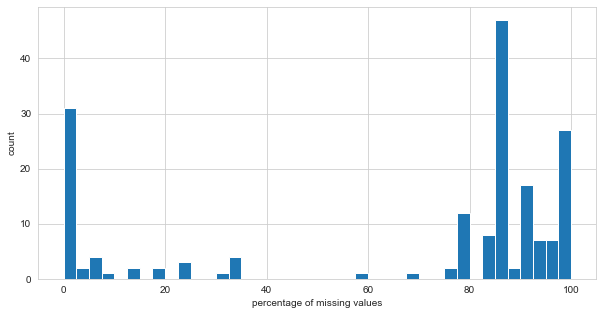

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(market_control_df["missing_percentage"], kde=False, bins = 40, hist_kws={"alpha":1})
plt.xlabel("percentage of missing values")
plt.ylabel("count");

Below, the output shows that 143 of the features with missing values are of type `float64`, while 20 of them are of type `object`.

In [11]:
market_control_df[market_control_df["missing"] != 0]["type"].value_counts()

float64    143
object      20
Name: type, dtype: int64

How many features have a percentage of missing values equal or higher than 50%?

In [12]:
market_control_df[(market_control_df["missing_percentage"] >= 50) & (market_control_df["type"] == "float64")].shape[0]

130

In [13]:
market_control_df[(market_control_df["missing_percentage"] >= 50) & (market_control_df["type"] == "object")].shape[0]

1

130 of the `float64` features and 1 `object` feature have 50% or more missing values. The decision, as a rule of thumb, is to drop these from the market dataset.

In [14]:
columns_to_drop = market_control_df[(market_control_df["missing_percentage"] >= 50)].index
market_df.drop(columns_to_drop, axis=1, inplace=True)
market_control_df = create_control_df(market_df)

print(f"The percentage of missing values in the market dataset is {round(100*(market_df.isna().sum().sum() / market_df.size))} %")

The percentage of missing values in the market dataset is 7 %


Later, the remaining missing values of each type of feature will be addressed.

### <a name="crapfeatures1">2.4 Identifying ID and Constant Features </a>

The code below identifies features with a number equal to the number of observations (i.e. behaves as an ID for the companies), and features with constant observations (i.e. all observatios are equal, which will not help any model to generalize predictions/classifications/etc.).  
The feature `id` is the only one that behaves as an identifier to the companies. We'll assign it to a separate variable called `IDs`.  
The feature `fl_epp` is the only one that has equal values for each observation, thus it'll be dropped from the dataset.

In [15]:
id_features = list(market_control_df[market_control_df["unique"] == market_df.shape[0]].index)
constant_features = list(market_control_df[market_control_df["unique"] == 1].index)
print(f"The identifier feature{'s are' if len(id_features) > 1 else ' is'} {id_features}")
print(f"The constant feature{'s are' if len(constant_features) > 1 else ' is'} {constant_features}")

IDs = market_df[id_features]
IDs.columns.name = ''
market_df.drop(constant_features + id_features, axis=1, inplace=True)
market_control_df = create_control_df(market_df)

The identifier feature is ['id']
The constant feature is ['fl_epp']


Below, the unique values for each categorical variable is shown.  
The variable `dt_situacao` has too many classes for a categorical variable, this may cause problems later on while imputing values. The feature dictionary indicates that it represents dates when "de_situacao" was registered by the IRS, but it has no more references to "de_situacao", so we'll just drop it.

In [16]:
market_control_df.loc[(market_control_df["type"] == "object") | (market_control_df["type"] == "bool"), "unique"].sort_values(ascending=False).head()

features
dt_situacao             7334
nm_divisao                87
nm_micro_regiao           73
de_natureza_juridica      67
de_ramo                   33
Name: unique, dtype: int64

In [17]:
market_df.drop("dt_situacao", axis=1, inplace=True)

In [18]:
market_control_df.loc[(market_control_df["type"] == "float64") | (market_control_df["type"] == "int64"), "unique"].sort_values(ascending=False)

features
empsetorcensitariofaixarendapopulacao    15419
idade_empresa_anos                       14198
vl_faturamento_estimado_grupo_aux         6794
vl_faturamento_estimado_aux               1920
idade_media_socios                        1010
vl_total_veiculos_leves_grupo              310
qt_filiais                                 304
vl_total_veiculos_pesados_grupo            296
idade_maxima_socios                        118
idade_minima_socios                        114
qt_socios_pf                                64
qt_socios                                   62
qt_socios_st_regular                        54
nu_meses_rescencia                          51
qt_socios_pj                                12
Name: unique, dtype: int64

### <a name="types">2.5 Verifying Features' Types </a>

Next, we'll evaluate the features' characteristics and modify their types as necessary, and create lists with features' names by type.

In [19]:
market_control_df = create_control_df(market_df)

#### <a name="floatfeat">2.5.1 Float Features </a>

In [20]:
market_control_df[market_control_df["type"] == "float64"]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
idade_empresa_anos,0,0.000,float64,14198,3.0712
vl_total_veiculos_pesados_grupo,1927,0.417,float64,296,0.0640
vl_total_veiculos_leves_grupo,1927,0.417,float64,310,0.0671
nu_meses_rescencia,45276,9.794,float64,51,0.0110
empsetorcensitariofaixarendapopulacao,143829,31.112,float64,15419,3.3353
qt_socios,115091,24.895,float64,62,0.0134
qt_socios_pf,115091,24.895,float64,64,0.0138
qt_socios_pj,115091,24.895,float64,12,0.0026
idade_media_socios,151602,32.793,float64,1010,0.2185


The code below assigns the names of float features to the list `float_features`, and the names if float features with missing values to `float_features_with_missing`. It also creates a table describing the float features.  
Checking their mean and median values through the next table, it's possible to infer that their distributions are right skewed (overall, means > medians).  
Also, the features `idade_media_socios`, `idade_maxima_socios`, `idade_minima_socios`, which represent ages, have negative minimum values.

In [21]:
float_features = list(market_control_df[market_control_df["type"] == "float64"].index)

float_features_with_missing = float_features.copy()
float_features_with_missing.remove("idade_empresa_anos")

market_df[float_features].describe()

features,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
count,462298.000000,460371.000000,460371.000000,417022.000000,318469.000000,347207.000000,347207.000000,347207.000000,310696.000000,310696.000000,310696.000000,307381.000000,4.347850e+05,4.347850e+05
mean,9.948677,3.591801,48.699177,25.007247,1308.005725,1.496326,1.476681,0.019645,42.816452,44.344131,41.355225,1.396082,8.020911e+05,3.367205e+08
std,9.615664,72.600352,1206.696804,9.679799,1161.889222,3.276626,3.258079,0.195166,12.626447,13.930385,12.514921,2.578793,3.099979e+07,7.114614e+09
min,0.016438,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,1.000000,0.000000e+00,4.104703e+04
25%,2.756164,0.000000,0.000000,22.000000,673.230000,1.000000,1.000000,0.000000,33.000000,34.000000,32.000000,1.000000,1.648512e+05,1.854576e+05
50%,6.704110,0.000000,0.000000,23.000000,946.680000,1.000000,1.000000,0.000000,42.000000,43.000000,40.000000,1.000000,2.100000e+05,2.100000e+05
75%,14.465753,0.000000,0.000000,25.000000,1518.080000,2.000000,2.000000,0.000000,51.000000,54.000000,50.000000,1.000000,2.100000e+05,2.100000e+05
max,106.432877,9782.000000,122090.000000,66.000000,75093.840000,246.000000,246.000000,13.000000,127.000000,127.000000,127.000000,179.000000,1.454662e+10,2.227618e+11


In [22]:
def create_distplots(df, features):
    """
    Shows a grid with subplots containing the distribution plots for every feature in the list.
    :param df: Pandas DataFrame containing the data.
    :param features: list or similar containing the continuous numeric features names.
    """
    if len(features) == 1:
        plt.figure(figsize=(20, 4.3))
        sns.distplot(df[features[0]], hist_kws={"alpha":1}, kde=False)
        plt.xlabel(features[0])
        plt.ylabel("count")
    else:
        nrows = len(features)//2
        ncols = 2
        n_figures = len(features)-1
        if len(features) % 2 != 0:
            nrows += 1
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4.3))

        flag = 0
        while flag <= n_figures:
            for pos_row in range(nrows):
                for pos_col in range(ncols):
                    if nrows == 1:
                        ax = axs[pos_col]
                    else:
                        ax = axs[pos_row, pos_col]
                    if (len(features)%2 != 0) and (pos_row == nrows-1) and (pos_col == 1):
                        flag+=1
                        continue
                    sns.distplot(df[features[flag]], ax=ax, hist_kws={"alpha":1}, kde=False)
                    plt.xlabel(features[flag])
                    plt.ylabel("count")
                    flag+=1

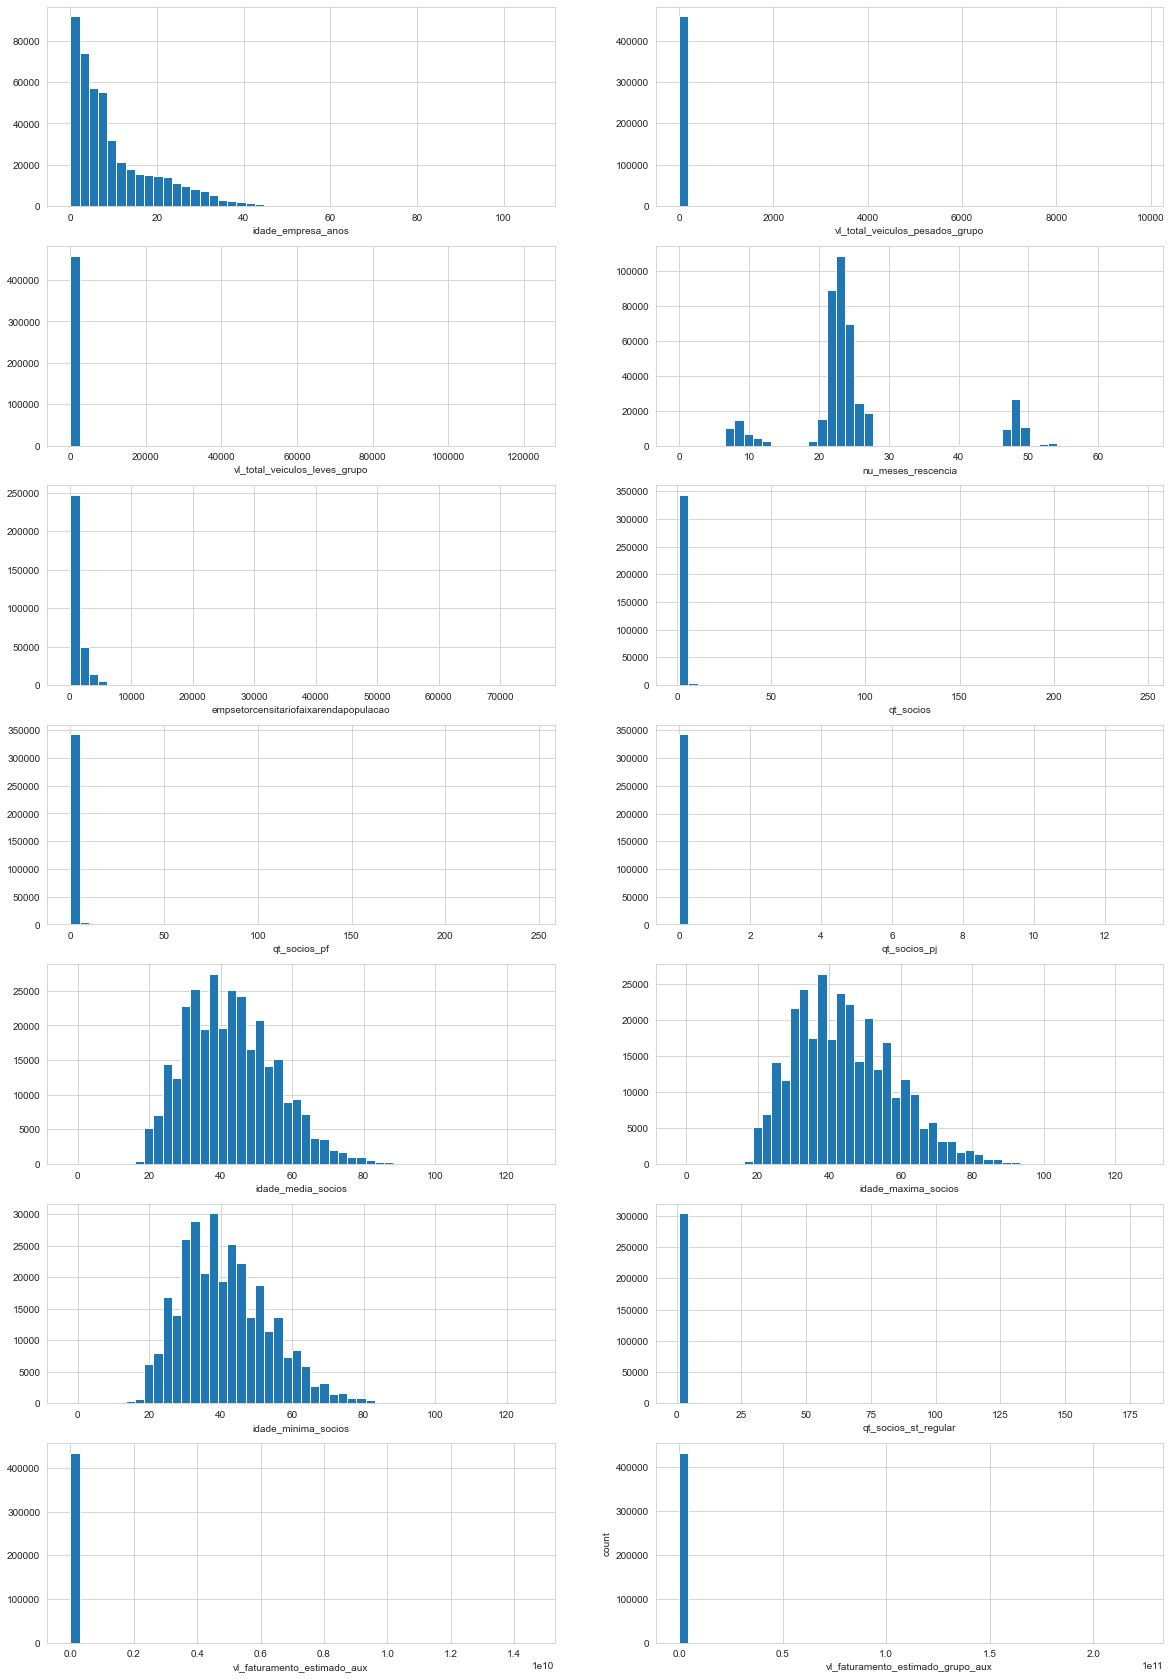

In [23]:
create_distplots(market_df, float_features)

Through the graphics and tables above it's possible to infer:  
* we confirm that the distributions are right skewed. Some have most values grouped together near 0.  
* Observing the x axis, it's possible to infer that some features present very extreme values.  
* The feature `nu_meses_rescencia` draws attention to it's three peaks, it's a multimodal distribution. 
* The features `idade_media_socios`, `idade_maxima_socios`, `idade_minima_socios` may be represented by a log-normal distribution.   
* Some present missing values.  

Since `idade_media_socios`, `idade_maxima_socios`, `idade_minima_socios` represent ages it should not have negative values. In the next code block we verify the most common values under 20, which seems like a good threshold considering the graphics, are also 20 - makes sense - we'll simply transform negative values into 20.

In [24]:
age_features = "idade_media_socios, idade_maxima_socios, idade_minima_socios".split(", ")
for feature in age_features:
    most_common_under_20 = market_df.loc[market_df[feature] <= 20, feature].value_counts().idxmax()
    print(f"{feature} most common under 20:\n{most_common_under_20}\n")
    market_df.loc[market_df[feature] <= 0, feature] = most_common_under_20 

idade_media_socios most common under 20:
20.0

idade_maxima_socios most common under 20:
20.0

idade_minima_socios most common under 20:
20.0



#### <a name="intfeat">2.5.2 Integer Features </a>

In [25]:
market_control_df[market_control_df["type"] == "int64"]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
qt_filiais,0,0.0,int64,304,0.0658


The code below assigns the name of integer features to the `integer_features` list. It also creates a table describing the feature.   
It's possible to infer that it's distributions is right skewed (overall, means > medians), much like the float features observed.  
There are no missing values in the feature.

In [26]:
integer_features = list(market_control_df[market_control_df["type"] == "int64"].index)

market_df[integer_features].describe()

features,qt_filiais
count,462298.000000
mean,28.737044
std,468.626094
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9647.000000


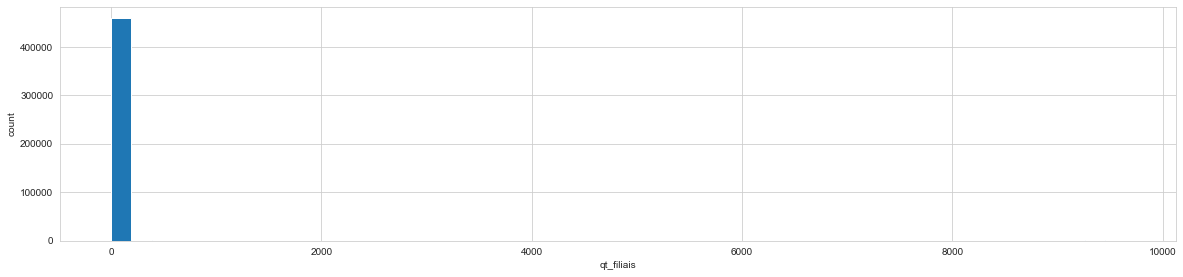

In [27]:
create_distplots(market_df, integer_features)

#### <a name="catfeat">2.5.3 Categorical Features </a>

In [28]:
market_control_df[(market_control_df["type"] == "object") | (market_control_df["type"] == "bool")]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
fl_matriz,0,0.000,bool,2,0.0004
de_natureza_juridica,0,0.000,object,67,0.0145
sg_uf,0,0.000,object,6,0.0013
natureza_juridica_macro,0,0.000,object,7,0.0015
de_ramo,0,0.000,object,33,0.0071
setor,1927,0.417,object,5,0.0011
idade_emp_cat,0,0.000,object,6,0.0013
fl_me,0,0.000,bool,2,0.0004
fl_sa,0,0.000,bool,2,0.0004


The table above shows that some features of type object have only two unique values. Usually, this is associated with boolean features. In the next code block we take a closer look and confirm that these are all actually boolean features. Their names' are stored in the `boolean_features` list, along with the features that were already of type bool, and the names of the boolean features with missing values are stored in `boolean_features_with_missing`.

In [29]:
boolean_features = list(market_control_df[
    ((market_control_df["type"] == "object") | (market_control_df["type"] == "bool"))
    & (market_control_df["unique"] == 2)].index)

boolean_features_with_missing = list(market_control_df[
    ((market_control_df["type"] == "object") | (market_control_df["type"] == "bool"))
    & (market_control_df["unique"] == 2) & (market_control_df["missing"] != 0)].index)

market_df[boolean_features].describe()

features,fl_matriz,fl_me,fl_sa,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,fl_simples_irregular,fl_passivel_iss
count,462298,462298,462298,462298,462298,462298,462298,462298,462298,460371,460371,460371,379585,379585,460371,460371
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,True,NAO,False,False,False,True,False,False,True
freq,433232,461083,453866,311398,461056,462230,256228,335468,236779,460091,457095,429687,199617,285545,460030,264741


The boolean feature `fl_rm` is of type object and presents the top value as "NAO" ("NO" in portuguese). We'll transform this and the other boolean features into 0s and 1s.

In [30]:
temp_onehot = OneHotEncoder(drop="if_binary", sparse=False, dtype=np.float)
market_df.loc[:, "fl_rm"] = temp_onehot.fit_transform(market_df[["fl_rm"]])
market_df.loc[:, boolean_features] = market_df[boolean_features].astype(np.float)
market_df[boolean_features].describe()

features,fl_matriz,fl_me,fl_sa,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,fl_simples_irregular,fl_passivel_iss
count,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,460371.000000,460371.000000,460371.000000,379585.000000,379585.000000,460371.000000,460371.000000
mean,0.937127,0.002628,0.018239,0.326413,0.002687,0.000147,0.445751,0.725653,0.487822,0.000608,0.007116,0.066651,0.525882,0.247744,0.000741,0.575060
std,0.242734,0.051198,0.133816,0.468901,0.051763,0.012127,0.497049,0.446185,0.499852,0.024654,0.084056,0.249416,0.499330,0.431703,0.027206,0.494334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The remaining object features are described in the table below. Their names are stored as `object_features`, and the object features that have missing values are assigned to `object_features_with_missing`.

In [31]:
object_features = list(market_control_df[
    (market_control_df["type"] == "object") & (market_control_df["unique"] > 2)
].index)

object_features_with_missing = list(market_control_df[
    (market_control_df["type"] == "object") & (market_control_df["unique"] > 2) & (market_control_df["missing"] != 0)].index)

market_df[object_features].describe().T

,count,unique,top,freq
features,,,,
de_natureza_juridica,462298,67,EMPRESARIO INDIVIDUAL,295756
sg_uf,462298,6,MA,127654
natureza_juridica_macro,462298,7,OUTROS,320211
de_ramo,462298,33,COMERCIO VAREJISTA,172404
setor,460371,5,COMERCIO,211224
idade_emp_cat,462298,6,1 a 5,138580
nm_divisao,460371,87,COMERCIO VAREJISTA,172404
nm_segmento,460371,21,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,211224
sg_uf_matriz,460359,27,MA,124823


In [32]:
def create_barplots(df, features, n_labels=None):
    """
    Shows a grid with subplots containing barplots for every feature in the list.
    :param df: Pandas DataFrame containing the data.
    :param features: list or similar containing the categorical features names.
    :param n_labels: integer, representes number of features' labels to plot. Uses the n features with more counts in descending order.
    """    
    if len(features) == 1:
        x = df[features].value_counts().head(n_labels)
        y = x.index        
        plt.figure(figsize = (25, 4.3))
        sns.barplot(x = x, y = y)
        plt.xlabel(features[0])
    else:
        n_figures = len(features) - 1
        nrows = len(features)//2
        ncols = 2
        if len(features) % 2 != 0:
            nrows += 1
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4.5))
        plt.subplots_adjust(wspace=1.25)
        
        flag = 0
        while flag <= n_figures:
            for pos_row in range(nrows):
                for pos_col in range(ncols):
                    if nrows == 1:
                        ax = axs[pos_col]
                    else:
                        ax = axs[pos_row, pos_col]
                    if (len(features)%2 != 0) and (pos_row == nrows-1) and (pos_col == 1):
                        flag+=1
                        continue
                    x = df[features[flag]].value_counts().head(n_labels)
                    y = x.index
                    sns.barplot(x=x, y=y, ax=ax)
                    plt.xlabel(features[flag])
                    flag+=1

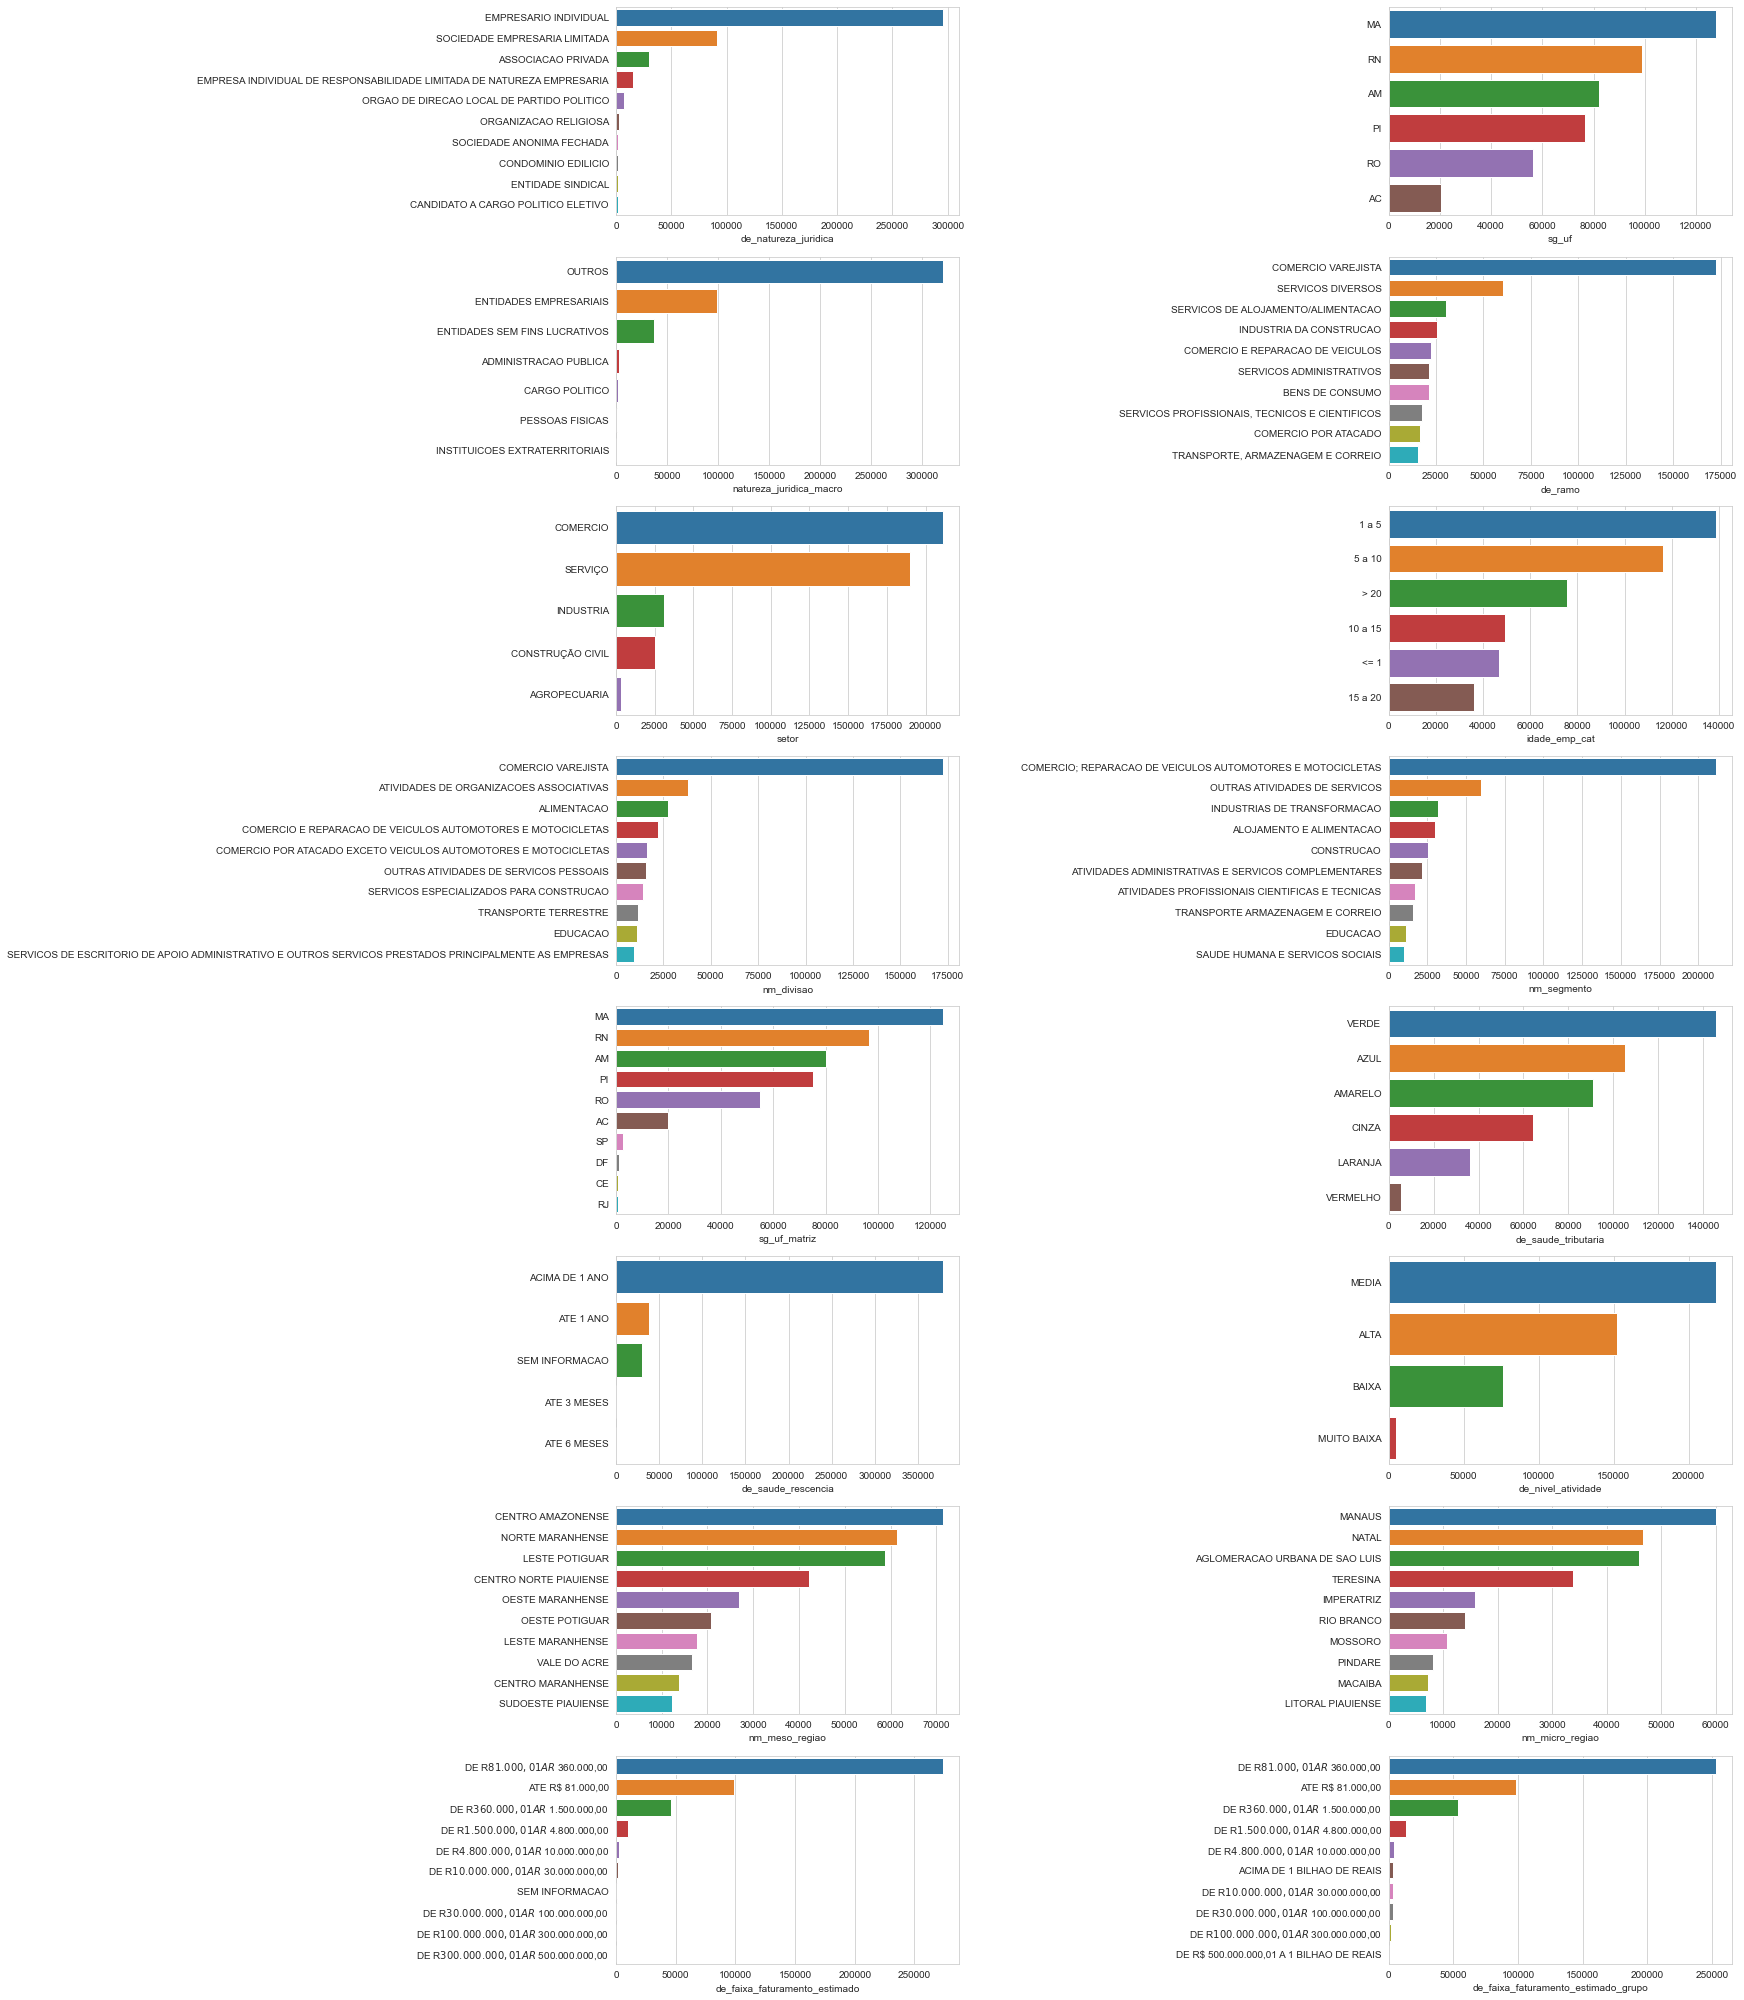

In [33]:
create_barplots(market_df, object_features, n_labels=10)

### <a name="missing2">2.6 Imputing Missing Values</a>

Below, it can be seen through the graphic that some remaining features have at least around 35% missing values or less.

In [34]:
market_control_df = create_control_df(market_df)

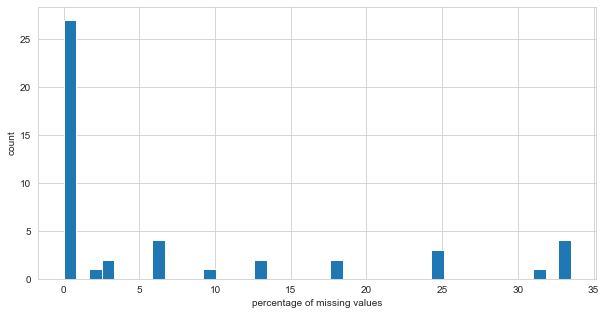

In [35]:
plt.figure(figsize=(10,5))
sns.distplot(market_control_df["missing_percentage"], kde=False, bins = 40, hist_kws={"alpha":1})
plt.xlabel("percentage of missing values")
plt.ylabel("count");

The next output shows that from the remaining 32 features with missing values, 20 are of type `float64`, while 12 of them are of type `object`. Remember that the boolean features were turned into the type float, but they should be treated as categorical.

In [36]:
print(f"From the {market_control_df.shape[0]} remaining features, {market_control_df[market_control_df['missing'] !=0 ].shape[0]} have missing values.")
print(f"\nTheir types are:\n{market_control_df[market_control_df['missing'] != 0]['type'].value_counts()}")

From the 47 remaining features, 31 have missing values.

Their types are:
float64    20
object     11
Name: type, dtype: int64


#### <a name="missingnum">2.6.1 Missing Values of Numeric Features</a>  
The folowing table shows the remaining `float64` features and their respective count and percentage of missing values.

In [37]:
market_control_df[(market_control_df["type"] == "float64")].sort_values(by="missing", ascending=False)

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
qt_socios_st_regular,154917,33.510,float64,54,0.0117
idade_minima_socios,151602,32.793,float64,113,0.0244
idade_maxima_socios,151602,32.793,float64,117,0.0253
idade_media_socios,151602,32.793,float64,1009,0.2183
empsetorcensitariofaixarendapopulacao,143829,31.112,float64,15419,3.3353
qt_socios_pj,115091,24.895,float64,12,0.0026
qt_socios_pf,115091,24.895,float64,64,0.0138
qt_socios,115091,24.895,float64,62,0.0134
fl_optante_simei,82713,17.892,float64,2,0.0004


The next code block presents a function to create vectors of values to impute in the features with missing values. To estimate the values, the features that do not have any missing values are used. Random Forests is used as regressor.

In [38]:
def impute_value_generator(df, targets, numeric_predictors, categorical_predictors, target_type="numeric", sample_size=5000):
    """
    Create a dictionary with each target feature as key. Each feature dictionary has, in turn, keys for the values created to impute the missing values\n
from the feature, and keys for the metrics generated. It can be used for numeric or categorical targets, and the sample size can be selected to improve\n
iteration speed.
    :param df: Pandas DataFrame that contains the data from the targets and predictors.
    :param targets: list or similiar, contains the names of the features for which the values will be created and appended to the output dictionary.
    :param numeric_predictors: list or similar, contains the names of the numeric features that will be used to predict/classify the missing values. \n
The predictors shouldn't contain missing values.
    :param categorical_predictors: list or similar, contains the names of the categorical features that will be used to predict/classify the missing values. \n
The predictors shouldn't contain missing values.
    :param target_type: string, accepts the values "numeric" and "categorical". It's used to select the pipeline to be applied - regresion or classification.
    :param sample_size: integer, represents the sample size used by the function. It's used to reduce the number of observations used by the function\n
thus speeding the iterations.
    :return: A dictionary which contains keys for each target. These have, in turn, keys for the impute values and for the metrics generated.
    """
    output = {}
     
    for target in targets:
        print(f"Executing iteration for {target}")
        
        # Sciki-learn pipeline and column transformer
        cat_pipeline = Pipeline(steps=[
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        num_pipeline = Pipeline(steps=[
            ("scaler", QuantileTransformer()) # Normalizer, QuantileTransformer
        ])

        transformer = ColumnTransformer(transformers=[
            ("categorical", cat_pipeline, categorical_predictors),
            ("numeric", num_pipeline, numeric_predictors)
        ])
        
        if target_type == "numeric":
            pipeline = Pipeline(steps=[
                ("transformer", transformer),
                ("regressor", RandomForestRegressor(n_jobs=-1))
            ])

        elif target_type == "categorical":            
            pipeline = Pipeline(steps=[
                ("transformer", transformer),
                ("classifier", RandomForestClassifier(n_jobs=-1))
            ])

        else:
            raise Exception("'target_type' must be either 'numeric' or 'categorical'")
        
        sample_features = numeric_predictors + categorical_predictors
        
        # Getting observations without missing values
        sample_df = df.loc[~df[target].isna(), sample_features + [target]].reset_index(drop=True)

        # Getting another sample of inferior size to speed up training. The indexes are chosen at random.
        idx = np.random.choice(len(sample_df), size=sample_size, replace=False)
        
        # Target and predictor assignment
        X = sample_df.drop(target, axis=1).iloc[idx]
        y = sample_df[target].iloc[idx]
        if target_type == "categorical":
            label_encoder = LabelEncoder()
            y = label_encoder.fit_transform(y)

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Fit the model and predict for test set
        pipeline.fit(X_train, y_train)
        prediction = pipeline.predict(X_test)                
        
        # Create variables to impute the missing values. The length of the created vector is equal to the number of missing values in the target
        # Getting a sample from the observations where the target variable is missing
        target_missing_sample = df.loc[df[target].isna(), sample_features].reset_index(drop=True)
        impute_variables = pipeline.predict(target_missing_sample)
        
        # Save created values, evaluate the prediction/classification for each feature, and save metrics
        if target_type == "numeric":            
            output.update({target: {
                "impute_variables": impute_variables,
                "mean_absolute_error": mean_absolute_error(prediction, y_test).round(2),
                "root_mean_squared_error": np.sqrt(mean_squared_error(prediction, y_test)).round(2),
                "pipeline": pipeline
            }})
            print(f"Metrics:\nmean absolute error: {output[target]['mean_absolute_error']}\n\
root mean squared error: {output[target]['root_mean_squared_error']}")
            print(169*"-")
            
        elif target_type == "categorical":
            output.update({target: {
                "impute_variables": impute_variables,
                "accuracy_score": accuracy_score(prediction, y_test).round(2),
                "f1_score": f1_score(prediction, y_test, average="weighted").round(2),
                "classification_report": classification_report(prediction, y_test, zero_division=0),
                "pipeline": pipeline,
                "label_encoder": label_encoder
            }})
            print(f"Metrics:\naccuracy: {output[target]['accuracy_score']}\n\
Weighted F1 score: {output[target]['f1_score']}")
            print(169*"-")
            
    return output

In [39]:
market_df_copy = market_df.copy() # making copy to prevent messing up the original dataset too much

In [40]:
# defining lists with the names of features without missing values.

object_features_without_missing = [feature for feature in object_features if (feature not in object_features_with_missing)]
boolean_features_without_missing = [feature for feature in boolean_features if (feature not in boolean_features_with_missing)]
float_features_without_missing = [feature for feature in float_features if (feature not in float_features_with_missing)]
# integer_features is already defined and it doesn't containt missing values
numeric_features_without_missing = float_features_without_missing + integer_features
categorical_features_without_missing = object_features_without_missing + boolean_features_without_missing

# defining lists with the names numeric and categorical features.
numeric_features = float_features + integer_features
categorical_features = object_features + boolean_features

print(f"Numeric features without missing values:\n{numeric_features_without_missing}\n\
Categorical features without missing values:\n{categorical_features_without_missing}\n")

Numeric features without missing values:
['idade_empresa_anos', 'qt_filiais']
Categorical features without missing values:
['de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 'de_ramo', 'idade_emp_cat', 'fl_matriz', 'fl_me', 'fl_sa', 'fl_mei', 'fl_ltda', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm']



Below, the function is applied to the numeric features, and generates values to be imputed. The features used for the prediciton are the numeric and categorical features without missing values, seen above.  

In [41]:
%%time
numeric_impute_dict = impute_value_generator(df=market_df_copy,
                                             targets=float_features_with_missing, 
                                             numeric_predictors=numeric_features_without_missing,
                                             categorical_predictors=categorical_features_without_missing,
                                             target_type="numeric",
                                             sample_size=50000)

Executing iteration for vl_total_veiculos_pesados_grupo
Metrics:
mean absolute error: 0.8
root mean squared error: 9.97
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for vl_total_veiculos_leves_grupo
Metrics:
mean absolute error: 8.32
root mean squared error: 324.02
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for nu_meses_rescencia
Metrics:
mean absolute error: 4.34
root mean squared error: 7.6
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for empsetorcensitariofaixarendapopulacao
Metrics:
mean absolute error: 683.92
root mean squared error: 1076.33
----------

Next, we plot the numeric values to be imputed.

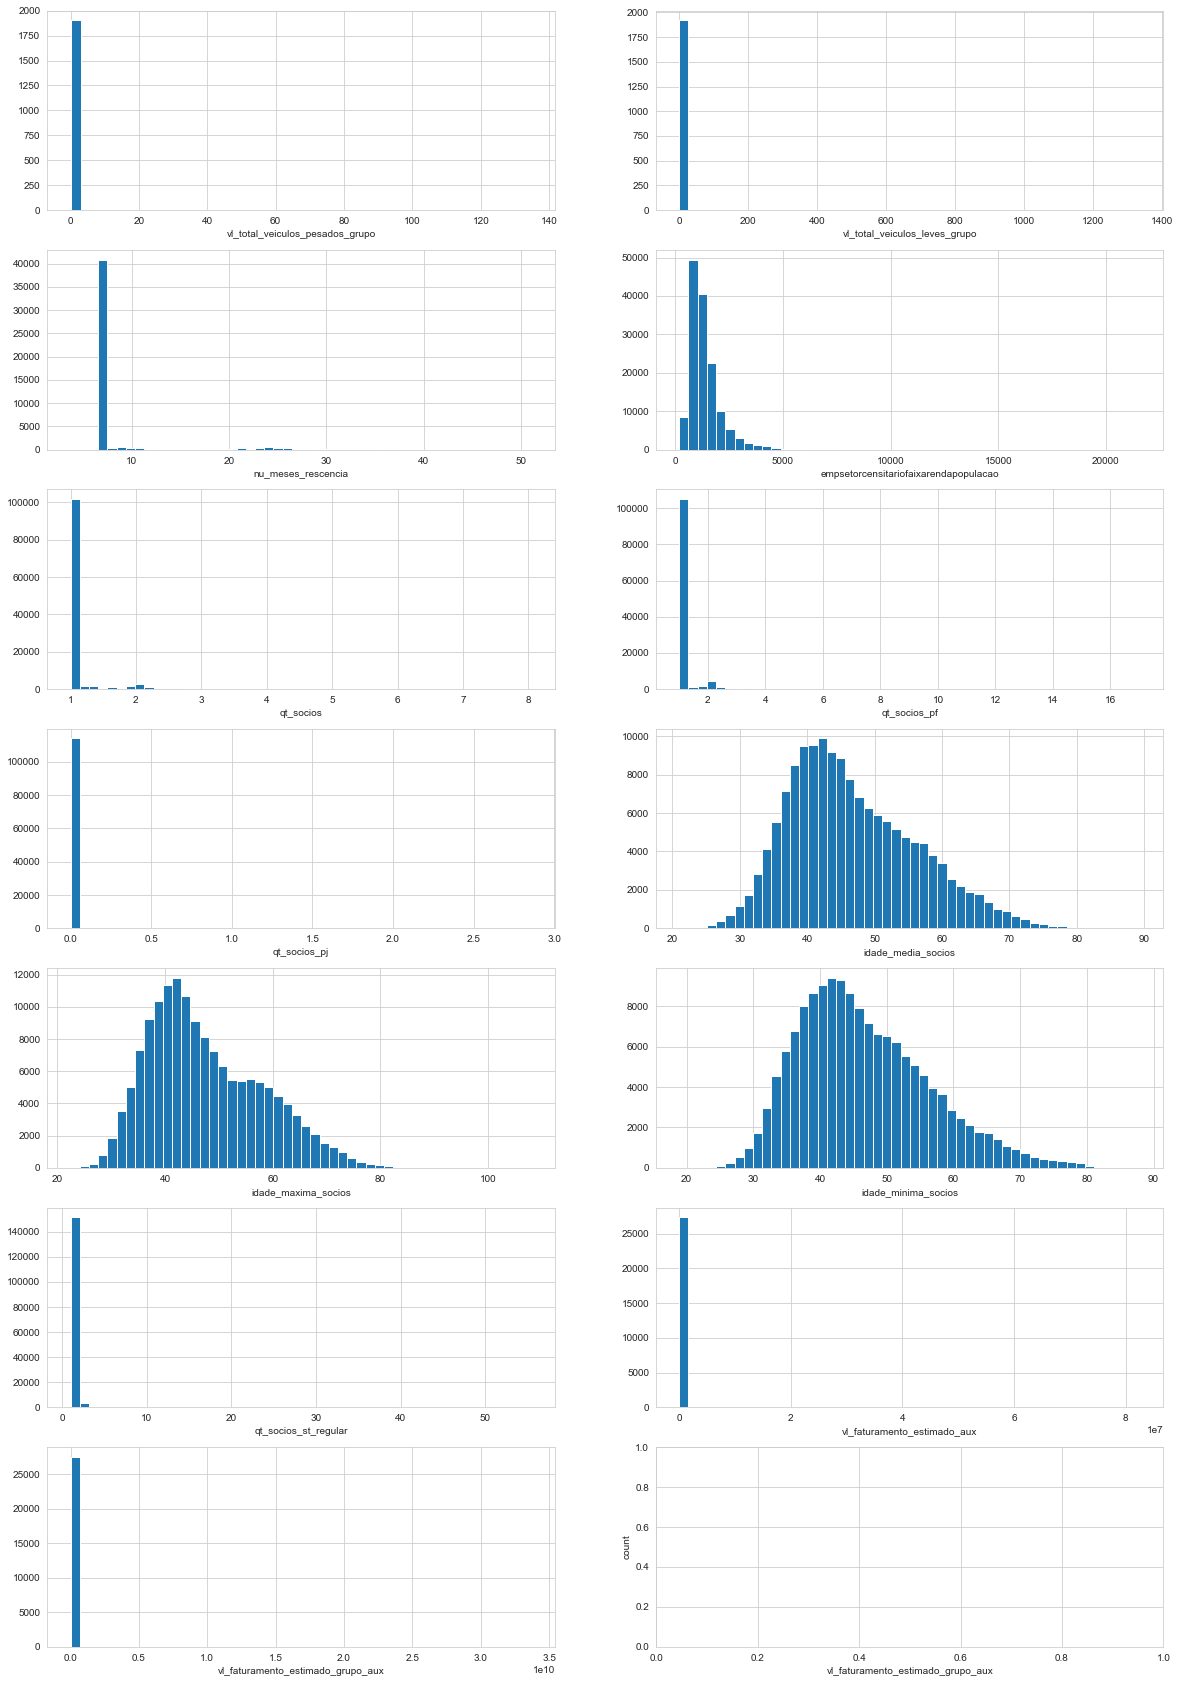

In [42]:
numeric_impute_df = pd.DataFrame({feature: pd.Series(numeric_impute_dict[feature]["impute_variables"]) for feature in [feature for feature in numeric_impute_dict.keys()]})

create_distplots(numeric_impute_df, numeric_impute_df.columns)

The next code block impute the missing values generated (they were created in sequence, so they'll match the missing values' positions), and creates yet another plot of all the float features without missing values - e.g. already imputed.

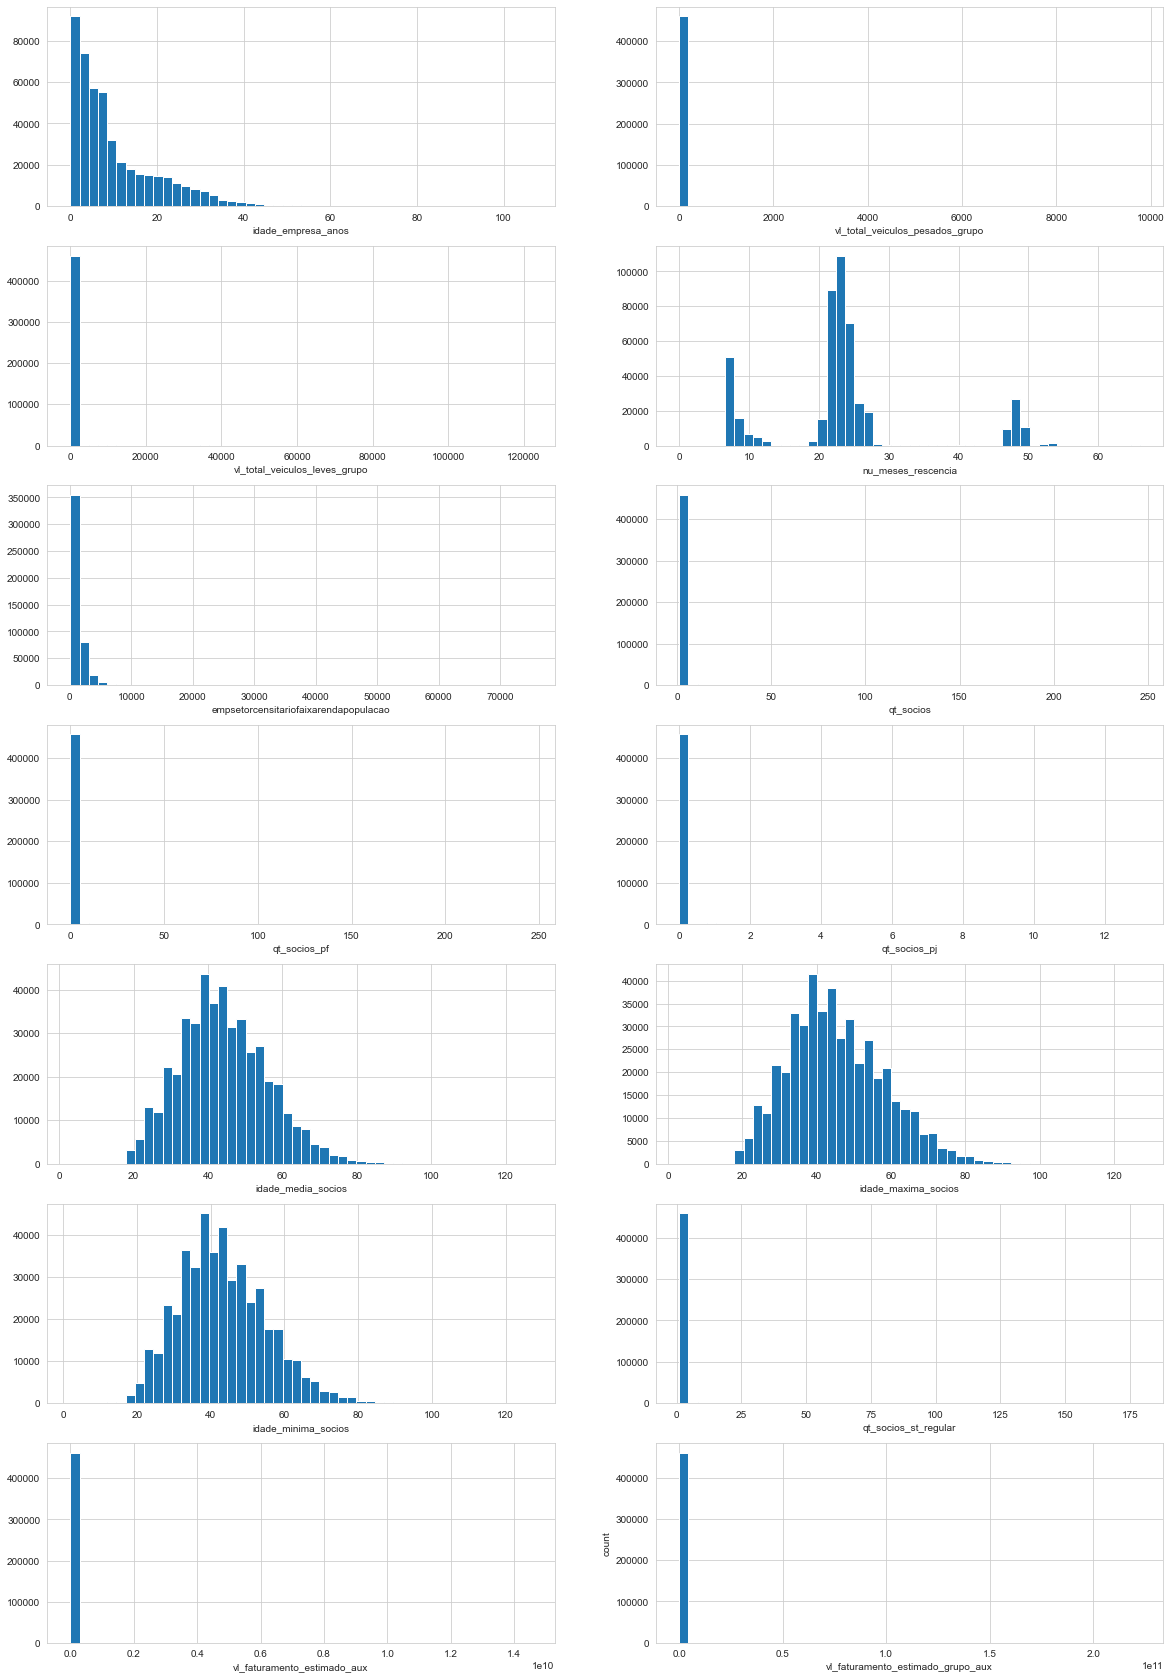

In [43]:
for feature in float_features_with_missing:
    market_df_copy.loc[market_df_copy[feature].isna(), feature] = numeric_impute_dict[feature]["impute_variables"]
create_distplots(market_df_copy, float_features)

The float features distributions with imputed missing values are now behaving simmilarly to the original distributions. The table below shows that there are no missing values among the `float64` features.

In [44]:
market_control_df = create_control_df(market_df_copy)
market_control_df.loc[float_features, :]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
idade_empresa_anos,0,0.0,float64,14198,3.0712
vl_total_veiculos_pesados_grupo,0,0.0,float64,385,0.0833
vl_total_veiculos_leves_grupo,0,0.0,float64,460,0.0995
nu_meses_rescencia,0,0.0,float64,1425,0.3082
empsetorcensitariofaixarendapopulacao,0,0.0,float64,128785,27.8576
qt_socios,0,0.0,float64,583,0.1261
qt_socios_pf,0,0.0,float64,542,0.1172
qt_socios_pj,0,0.0,float64,120,0.0260
idade_media_socios,0,0.0,float64,54796,11.8530


#### <a name="missingcat">2.6.2 Missing Values of Categorical Features</a>
The following code blocks presents the remaining categorical features (of type object and bool), and their respective count and percentage of missing values.

In [45]:
pd.concat([market_control_df.loc[object_features], market_df[object_features].describe().T[["count", "top", "freq"]]], axis=1).sort_values(by="missing", ascending=False)

,missing,missing_percentage,type,unique,unique_percentage,count,top,freq
features,,,,,,,,
nm_meso_regiao,58698,12.697,object,19,0.0041,403600,CENTRO AMAZONENSE,71469
nm_micro_regiao,58698,12.697,object,73,0.0158,403600,MANAUS,60008
de_faixa_faturamento_estimado,27513,5.951,object,12,0.0026,434785,"DE R$ 81.000,01 A R$ 360.000,00",273861
de_faixa_faturamento_estimado_grupo,27513,5.951,object,11,0.0024,434785,"DE R$ 81.000,01 A R$ 360.000,00",252602
de_saude_tributaria,14851,3.212,object,6,0.0013,447447,VERDE,145430
de_saude_rescencia,14851,3.212,object,5,0.0011,447447,ACIMA DE 1 ANO,378896
de_nivel_atividade,11168,2.416,object,4,0.0009,451130,MEDIA,217949
sg_uf_matriz,1939,0.419,object,27,0.0058,460359,MA,124823
setor,1927,0.417,object,5,0.0011,460371,COMERCIO,211224


In [46]:
market_control_df.loc[boolean_features].sort_values(by="missing", ascending=False)

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
fl_optante_simples,82713,17.892,float64,2,0.0004
fl_optante_simei,82713,17.892,float64,2,0.0004
fl_spa,1927,0.417,float64,2,0.0004
fl_antt,1927,0.417,float64,2,0.0004
fl_veiculo,1927,0.417,float64,2,0.0004
fl_simples_irregular,1927,0.417,float64,2,0.0004
fl_passivel_iss,1927,0.417,float64,2,0.0004
fl_matriz,0,0.000,float64,2,0.0004
fl_me,0,0.000,float64,2,0.0004


Simmilarly to the imputation done to fhe numeric features, we'll use random forests to classify the missing values. As predictors, this time we'll use all the numeric features, in which values have been imputed, and the categorical features without missing values.

In [47]:
categorical_features_with_missing = object_features_with_missing + boolean_features_with_missing
print(f"Categorical features with missing values:\n{categorical_features_with_missing}")

Categorical features with missing values:
['setor', 'nm_divisao', 'nm_segmento', 'sg_uf_matriz', 'de_saude_tributaria', 'de_saude_rescencia', 'de_nivel_atividade', 'nm_meso_regiao', 'nm_micro_regiao', 'de_faixa_faturamento_estimado', 'de_faixa_faturamento_estimado_grupo', 'fl_spa', 'fl_antt', 'fl_veiculo', 'fl_optante_simples', 'fl_optante_simei', 'fl_simples_irregular', 'fl_passivel_iss']


In [48]:
%%time
categorical_impute_dict = impute_value_generator(df=market_df_copy,
                                                 targets=categorical_features_with_missing,
                                                 numeric_predictors=numeric_features,
                                                 categorical_predictors=categorical_features_without_missing,
                                                 target_type='categorical',
                                                 sample_size=50000)

Executing iteration for setor
Metrics:
accuracy: 0.99
Weighted F1 score: 0.99
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for nm_divisao
Metrics:
accuracy: 0.87
Weighted F1 score: 0.89
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for nm_segmento
Metrics:
accuracy: 1.0
Weighted F1 score: 1.0
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for sg_uf_matriz
Metrics:
accuracy: 0.98
Weighted F1 score: 0.99
------------------------------------------------------------------------------------------------------------------------------------------------------------------

Next, the categorical features with missing values are imputed and countplots are generated.

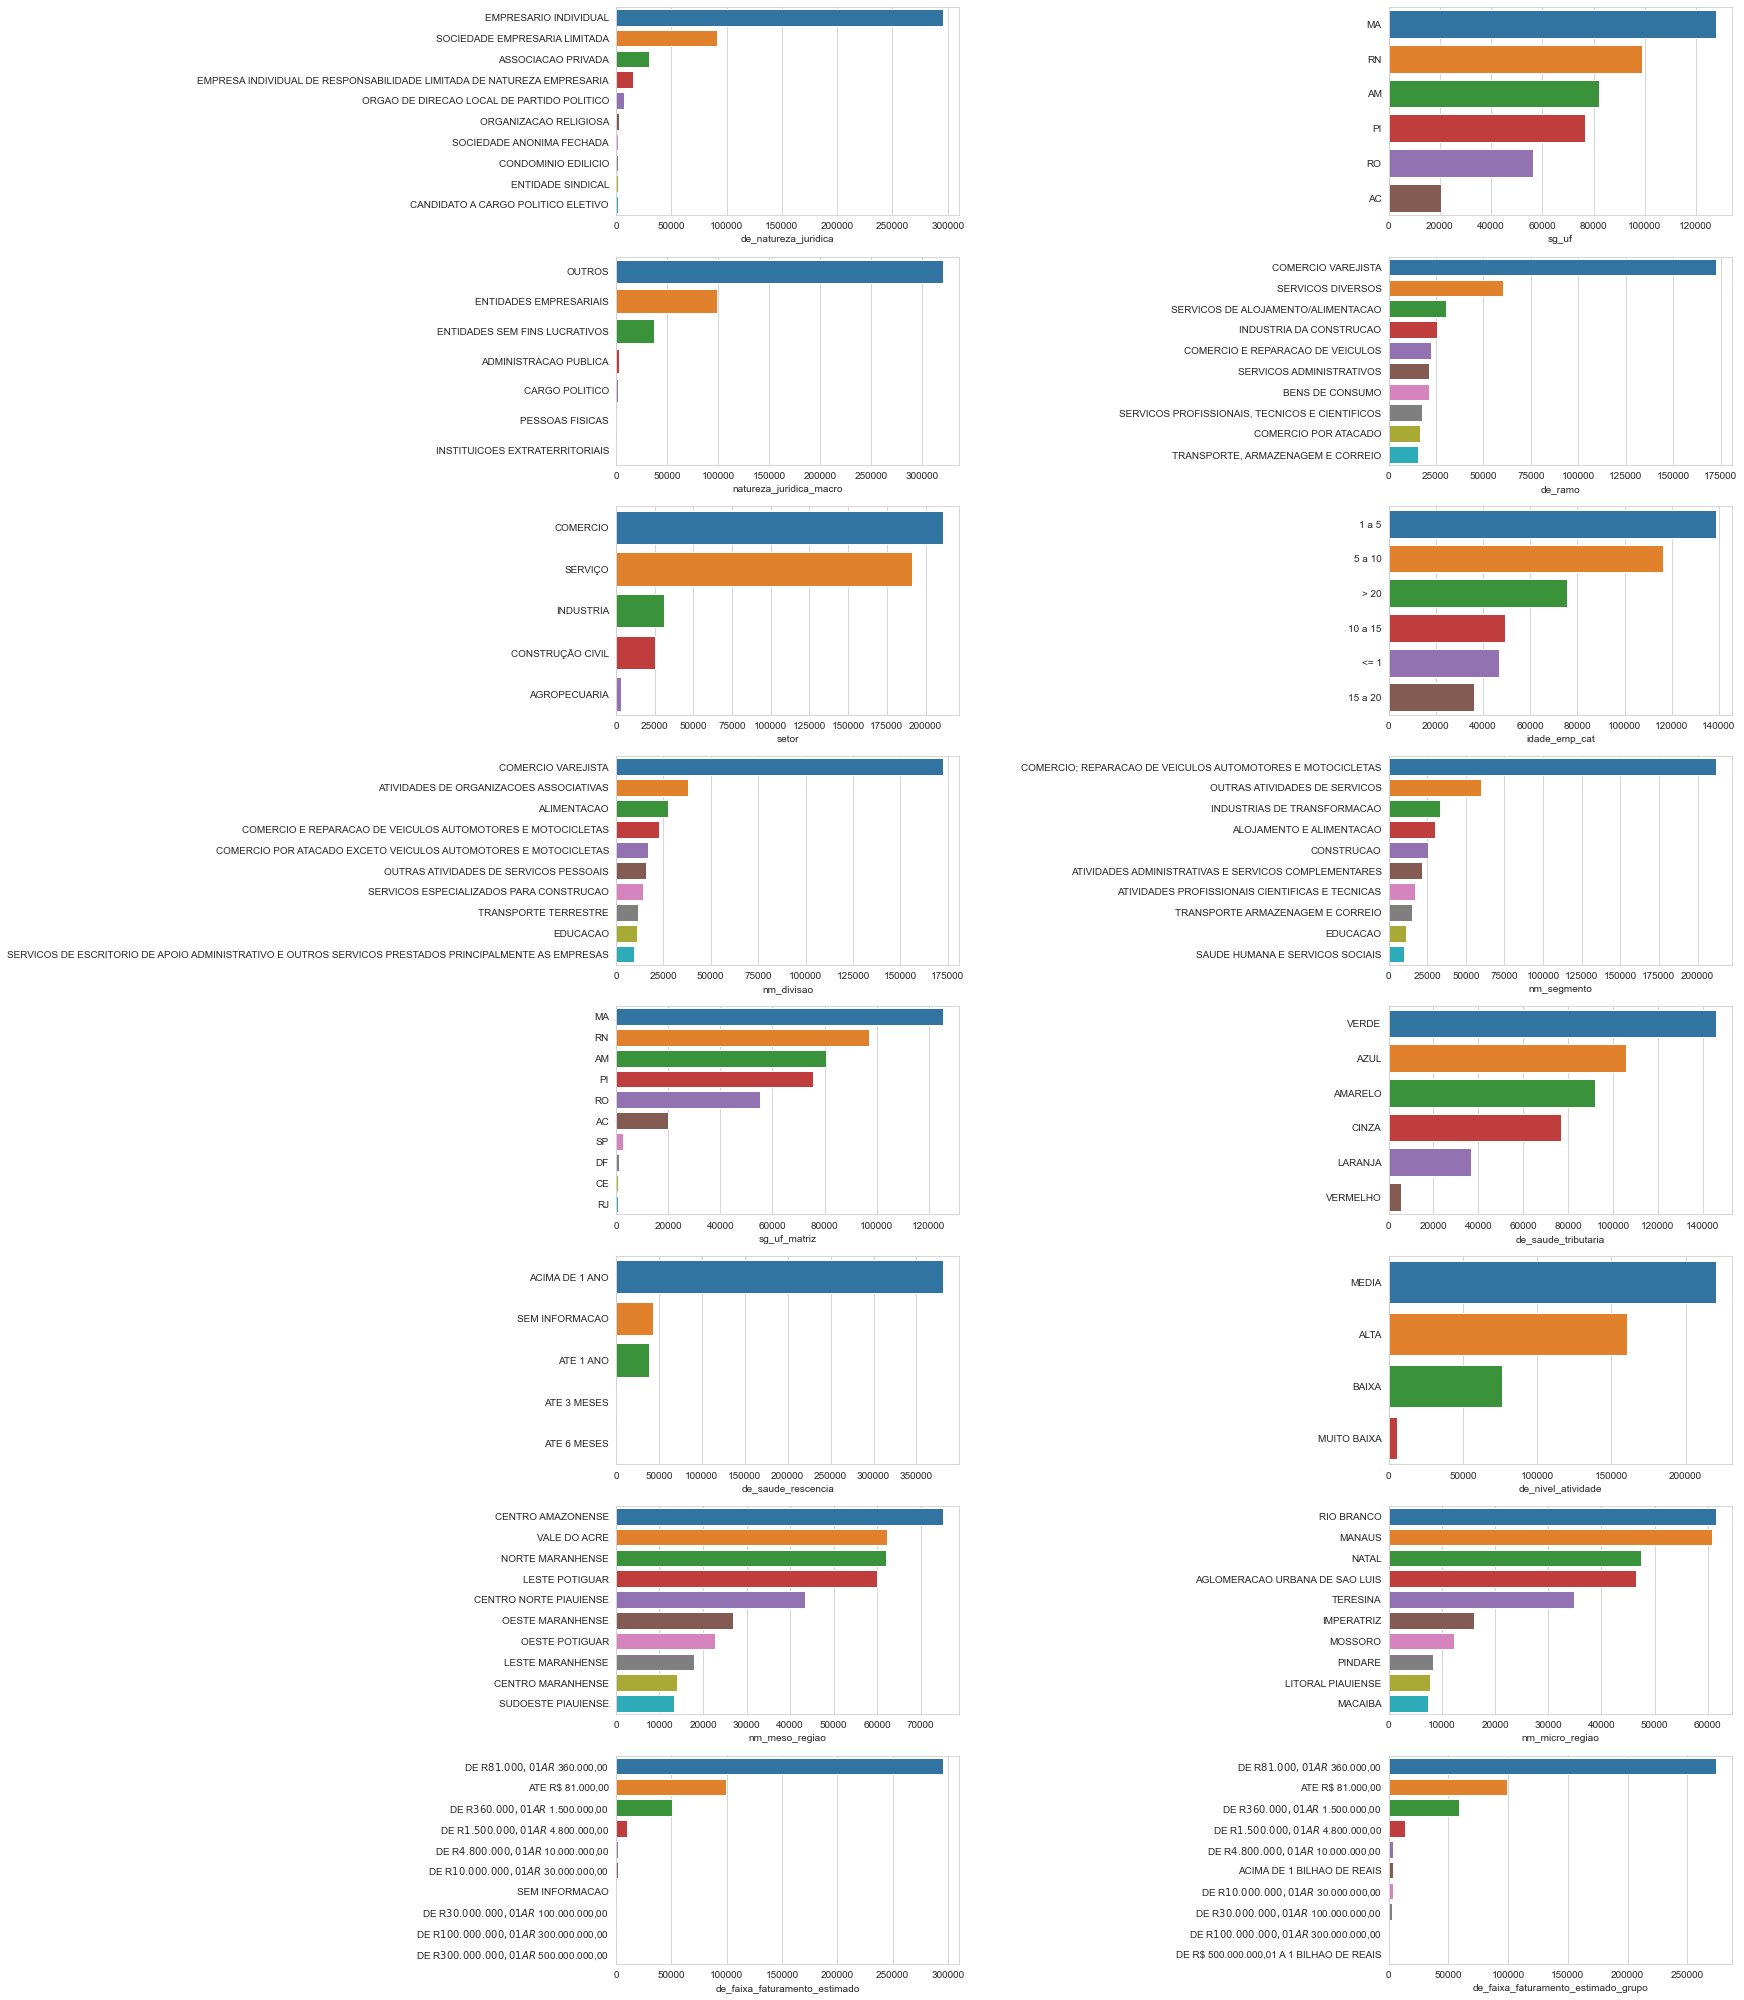

In [49]:
for feature in categorical_features_with_missing:
    # Re-transforming the predicted classes from numbers to labels.
    _to_impute = categorical_impute_dict[feature]["label_encoder"].inverse_transform(categorical_impute_dict[feature]["impute_variables"])
    market_df_copy.loc[market_df_copy[feature].isna(), feature] = _to_impute
create_barplots(market_df_copy, object_features, n_labels=10)

The result printed next shows that there are no more missing values in our dataset.

In [50]:
print(f"The percentage of missing values in the market dataset is {round(100*(market_df_copy.isna().sum().sum() / market_df_copy.size))} %")

The percentage of missing values in the market dataset is 0 %


### <a name="featuresel">2.7 Feature Selection</a>
In the next step we try to reduce our feature space by using a feature selection technique that can deal with sparse matrices.

In [51]:
market_control_df = create_control_df(market_df_copy)
unique_classes = market_control_df.loc[categorical_features, "unique"].sum()
estimated_max_components = unique_classes + len(numeric_features)
print(f"The estimated max number of components is {estimated_max_components}")

The estimated max number of components is 436


In [52]:
def truncated_SVD_selector(df, numeric_features, categorical_features, n_components=250, evr=None):
    """
    Feature selection by the use of truncatedSVD.
    :param df: Pandas DataFrame with the data for the feature selection to be applied.
    :param numeric_features: list, must contain names of the numeric features in the dataset.
    :param categorical_features: list, must contain names of the categorical features in the dataset.
    :param n_components: integer, number of principal components.
    :return: array containing the number of features defined with n_components and the pipeline used to process the features.
    """    
    
    # Sciki-learn pipeline and column transformer
    cat_pipeline = Pipeline(steps=[
        ("onehot", OneHotEncoder(drop="first", dtype=np.int32))
    ])

    num_pipeline = Pipeline(steps=[
        ("scaler", Normalizer()) # Normalizer, RobustScaler, QuantileTransformer
    ])
    
    transformer = ColumnTransformer(transformers=[
        ("categorical", cat_pipeline, categorical_features),
        ("numeric", num_pipeline, numeric_features)
    ])
    
    pipeline = Pipeline(steps=[
        ("transformer", transformer),
        ("feature_selection", TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=42))
    ])   
    
    processed_df = pipeline.fit_transform(df)
    
    if not evr:
        return processed_df, pipeline
    
    else:
        explained_variance_ratio = np.cumsum(pipeline.get_params()["feature_selection"].explained_variance_ratio_)
        n_PCs = explained_variance_ratio[(explained_variance_ratio <= evr)].argmax()
        return processed_df[:, 0:n_PCs], pipeline        
    

def evr_plot(pipeline):
    """
    Plot cumulative explained variance ratio for the feature selection algorithm used in the pipeline. To be used in conjunction with the output pipeline of\n
the function "truncated_SVD_selector".
    :param pipeline: output of the function "truncated_SVD_selector", scikit-learn pipeline with a step called "feature_selection", which contains the\n
feature selection algorithm.
    """
    explained_variance_ratio = pipeline.get_params()["feature_selection"].explained_variance_ratio_
    g = sns.lineplot(np.arange(len(explained_variance_ratio)), np.cumsum(explained_variance_ratio))
    g.axes.axhline(0.99, ls="--", color="red")
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance');  

In [53]:
%%time
array_df_final, feature_selection_pipeline = truncated_SVD_selector(df=market_df_copy,
                                                                     numeric_features=numeric_features,
                                                                     categorical_features=categorical_features,
                                                                     n_components=250)

Wall time: 37.7 s


It's possible to see through the plot below the approximate number of components to obtain 99% explained variance ratio - observe that the function encodes categorical features with one hot encoder thus the feature space is way bigger (contains around 400 features, as denoted before) than the previously treated dataframe, which contained 47 features, as seen below.

In [54]:
print(f"Dimension of the dataframe without missing values: {market_df_copy.shape}")
print(f"Dimension of the dataframe encoded with one hot encoding: {array_df_final.shape}\n    ps*: it can reach at least 420 components")

Dimension of the dataframe without missing values: (462298, 47)
Dimension of the dataframe encoded with one hot encoding: (462298, 250)
    ps*: it can reach at least 420 components


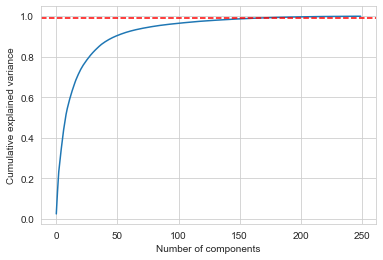

In [55]:
evr_plot(feature_selection_pipeline)

Below, the feature selection function is called again, this time with the paramater evr set to 0.99 (for explained variance ratio).

In [56]:
%%time
array_df_final, feature_selection_pipeline = truncated_SVD_selector(df=market_df_copy,
                                                                    numeric_features=numeric_features,
                                                                    categorical_features=categorical_features,
                                                                    n_components=250,
                                                                    evr=0.995)

Wall time: 26.3 s


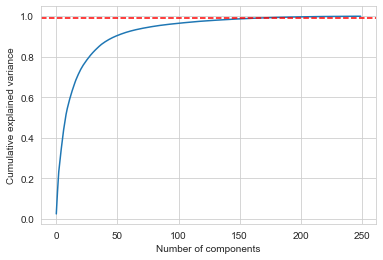

In [57]:
evr_plot(feature_selection_pipeline)

In [58]:
print(f"Dimension of the processed market dataset: {array_df_final.shape}")

Dimension of the processed market dataset: (462298, 190)


___
[go back to top](#top)  
___
## <a name="overview">3 Algorithm Evaluation and Overview of the Steps to be Taken</a>

### <a name="typesrecsys">3.1 Types of Recommender Systems</a>

A type of algorithm known as Recommender System is the first thing that comes to mind considering the problem at hand: to provide an automated service that recommends new business leads to a user given his current clients portfolio. There's many different approaches to create a Recommender System, which depend on the original data format and size.  
The main approaches are:  

* [Simple Recommenders / Popularity Based System](https://www.datacamp.com/community/tutorials/recommender-systems-python): In popularity based recommender systems, the "knowledge of the masses" is used to make recommendations based on, you guessed, what most people like. There is a nice example in the link.

* [Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering): In collaborative filtering, the interests of many users (hence collaborative) are used to filter the data and predict the tastes of a certain user. The main idea is that a user gets better recommendations from people that have similar preferences. Usually, it is required that the data presents a user database, and item database, and a way to infer user preferences regarding the items, which may be explicit, like ratings given by each user to the respective item, or it may be some sort of implicit rating as well, like clicks on a type of add. Commonly, the system may be constructed by looking for users that rate items simmilarly, or look for simmilarities between items.  

* [Content Based Fitering](http://recommender-systems.org/content-based-filtering/): In content based filtering, the idea is to compare items based on their features/contents, and then recommend similar items to the ones a user has interacted in the past (like with the profiles at hand). There are several learning techniques to learn a user profile. 

* [Hybrid Methods](https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems): As the name says, this approach combines different techinques, as in content based filtering, collaborative filtering, etc., to create recommendations based not only on user ratings, but also in items features and characteristics.

### <a name="approach">3.2 Selected Approach and Steps</a>

That said, after experimentation, research and input from felow students and the community, **For this project, a Content Based Filtering Recommender System based in *Logistic Regression* is going to be used**. It's not quite a recommender system per se ([at least not like the ones I found](#refs)), e.g. it does not uses technologies as TF-IDF, Matrix Factorization, similarity comparison through euclidean/cosine distances, but it does recommend leads!  
The steps taken, overall, are:  
* The companies that are already clients can be used as targets provided they're encoded as 0s and 1s, or False and True.  
* The processed database can be used as predictors.  
* We aim not to obtain the predictions per se, but the logistic regression predicted probability that the company is indeed a client. With this, we can sort the companies recommended based on the predicted probability that they're clients.  
* Since there's almost 470E3 companies, we'll use KMeans clustering to group the companies and train logistic regressions for each group.  
* The data is very imbalanced - each portfolio have around 500 companies, and we've just cited the size of the dataframe with all companies. We'll use SMOTE oversampling along the training sets to address this issue.  
* Metrics will be shown for the trained logistic regression on portfolio 2 - then, recommendations will be made for all portfolios.
* The recommendations made will be evaluated through the MAP@k metric.  

It can be argued that it's a matter of adapting the dataset so that we obtain the required format required by each approach. That said, to the problem and dataset at hand:

* Three portfolios are presented - our user base is of three, and usually to use collaborative filtering many users would be needed (creating simulated profiles could be an idea here).

* These portfolios do not present user ratings (not explicitly, at least) on each of the "items", which are the clients.

* As seen in the previous exploratory data analysis section, each client presents several features that may be used to identify similar observations/clients.  

___
[go back to top](#top)  
___
## <a name="training">4 Model Training</a>
### <a name="portfoliodata">4.1 Load Portfolio Data</a>

In [59]:
portfolio1 = pd.read_csv('estaticos_portfolio1.csv', usecols=["id"])
portfolio2 = pd.read_csv('estaticos_portfolio2.csv', index_col=0)
portfolio3 = pd.read_csv('estaticos_portfolio3.csv', index_col=0)

Checking if the clients ID's from the portfolios are in the main database.

In [60]:
def check_portfolio_info(database, portfolio):
    """
    Check if the database contains the portfolios' IDs.
    The portfolio and database must contain `id` as a feature.
    :param database: Pandas DataFrame, contains all the companies' IDs as feature `id`.
    :param portfolio: Pandas DataFrame, contains only the portfolio clients' IDs as feature `id`.
    """
    print(f"Database size: {database.shape[0]}")
    print(f"Portfolio size: {portfolio.shape[0]}")

    # Test - check if database contains portfolios' IDs
    assert np.all(portfolio["id"].isin(database["id"])), "Test 1: NOT OK - Not all the portfolios' ids are in the database"
    print("Test: OK - All the portfolios' ids are in the database\n")
    print(169*"-")

In [61]:
for portfolio, number in zip([portfolio1, portfolio2, portfolio3], range(1,4)):
    print(f"\nTesting Portfolio {number}\n")
    check_portfolio_info(IDs, portfolio)


Testing Portfolio 1

Database size: 462298
Portfolio size: 555
Test: OK - All the portfolios' ids are in the database

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Testing Portfolio 2

Database size: 462298
Portfolio size: 566
Test: OK - All the portfolios' ids are in the database

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Testing Portfolio 3

Database size: 462298
Portfolio size: 265
Test: OK - All the portfolios' ids are in the database

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### <a name="pc">4.2 "Companies Profile" Table / Principal Components DataFrame</a>

Below, we're getting all companies IDs and principal components in a dataframe.

In [62]:
columns_names = []
for PC in range(1, array_df_final.shape[1]+1):
    columns_names.append("PC_" + str(PC))
companies_profile = pd.DataFrame(array_df_final, columns=columns_names, index=IDs["id"])

print(f"Dimension of companies profile table: {companies_profile.shape}")

Dimension of companies profile table: (462298, 190)


In [63]:
companies_profile.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_181,PC_182,PC_183,PC_184,PC_185,PC_186,PC_187,PC_188,PC_189,PC_190
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,2.291293,0.964369,0.527222,1.796745,1.201817,-1.233017,-0.764109,-0.459613,0.686197,-0.418890,...,0.001056,0.004129,-0.004412,0.005318,-0.001308,0.006111,-0.001624,-0.002923,-0.000679,0.001758
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,3.337279,1.045713,0.567608,-0.534452,-1.260968,-0.369280,0.264200,0.904627,1.875089,0.032237,...,-0.000965,0.000029,0.002811,0.002002,-0.000966,0.000833,0.001240,0.001318,0.002590,-0.003793
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,3.106881,0.388183,1.939861,0.699195,-0.493313,1.746171,0.064297,-0.012322,-0.461038,-0.450938,...,0.003403,-0.007225,0.004875,0.000324,0.000550,-0.004423,-0.000023,0.003290,0.003679,-0.003151
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,3.384404,1.457713,0.213154,0.561428,-1.116825,1.216855,0.009685,0.010204,-0.625651,0.257475,...,0.001191,0.001830,-0.001038,-0.002433,0.001248,-0.004160,0.001444,0.001008,-0.003952,0.005006
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,3.178611,1.100711,0.613735,0.722987,-0.466838,-1.374149,-0.773210,0.010743,-0.239919,-0.135822,...,0.001608,0.000967,-0.006866,0.003631,-0.001342,-0.004625,0.002421,0.001266,-0.001206,0.001424


### <a name="cluster">4.3 Clustering Companies with MiniBatchKMeans</a>

Next, we're clustering the companies based on their features to reduce the number of companies we model upon each iteration and improve predictions. We set a minimum limit to the reduction in heterogeneity for increases in the number of clusters.  
The KMeans algorithm divides the companies (see companies_profile above) in three clusters.

In [64]:
def find_cluster(df, n_features=1, sse_limit=0.05, flag_start=2):
    """
    Use MiniBatchKMeans to find clusters in the dataset. It compares two groupings at each iterations, if\
 reduction in heterogeneity is inferior to threshold, return fitted algorithm.
    :param df: Pandas DataFrame to find clusters on.
    :param n_features: integer, number of features to be used from the dataframe.
    :param sse_limit: float, limit to the reduction in heterogeneity
    :param flag_start: integer, minimum number of clusters to start the comparisons.
    :return: fitted MiniBatchKMeans object and pandas series with cluster labels.
    """
    #build two kmeans models starting with 2 and 3 clusters and repeat until dss < sse_limit  
    flag = flag_start
    kmeans1 = MiniBatchKMeans(n_clusters=flag, random_state=42)
    
    if n_features == 1:
        kmeans1.fit(df.iloc[:, 0].values.reshape(-1, 1))
    else:
        kmeans1.fit(df.iloc[:, 0:n_features].values)
        
    while True:
        flag += 1
        kmeans2 = MiniBatchKMeans(n_clusters=flag, random_state=42)
        if n_features == 1:
            kmeans2.fit(df.iloc[:, 0].values.reshape(-1, 1))  
        else:
            kmeans2.fit(df.iloc[:, 0:n_features].values) 
    
        #decision criterion - additional cluster should reduce heterogeneity to not less than sse_limit
        dss = (kmeans1.inertia_ - kmeans2.inertia_)/kmeans1.inertia_
        print(f"From {flag-1} to {flag} clusters -> Reduction in heterogeneity: {dss}")
        if dss < sse_limit:
            break
        kmeans1 = kmeans2
    return kmeans1, pd.Series(kmeans1.labels_, name="cluster")

In [65]:
%%time
kmeans, cluster_labels = find_cluster(companies_profile, n_features=5, sse_limit=0.2, flag_start=1) # fitted kmeans and cluster labels, turn to pd.Series

From 1 to 2 clusters -> Reduction in heterogeneity: 0.29739367900766767
From 2 to 3 clusters -> Reduction in heterogeneity: 0.25904861005858837
From 3 to 4 clusters -> Reduction in heterogeneity: 0.16033190950739293
Wall time: 7.34 s


### <a name="importantfunctions">4.4 Functions to Create Rating table and to Train Logistic Regression by Cluster</a>

Now, some functions are defined and used to train the model by cluster:
* `create_rating_df` maps the clients in a portfolio to the companies_profile and to a defined cluster.
* `train_classifiers` for each cluster and based on the portfolios' clients and the companies_profile - applies train_test_split, SMOTE oversampling, trains logistic regression, makes predictions and saves the trained model along with metrics. 

In [66]:
def create_rating_df(portfolio, companies_profile, cluster_labels):
    """
    Create rating dataframe - a dataframe with columns:
    - id: the id of the company
    - client: if the company is a client (present) on the porfolio
    - cluster: to which cluster the company belongs
    :param portfolio: pandas dataframe with column "id", portfolio with client companies ids.
    :param companies_profile: pandas dataframe with all companies ids as index and companies features.
    :param cluster_labels: pandas series, has cluster labels obtained through KMeans.
    :return: pandas dataframe with columns cited above.
    """
    rating_df = companies_profile.reset_index()["id"] # get all IDs
    portfolio_flag = IDs["id"].isin(portfolio["id"]) # 1 means it is a client
    portfolio_flag.name = "client"
    rating_df = pd.concat([rating_df, portfolio_flag, cluster_labels], axis=1) # concatenate IDs, client flag and cluster labels
    return rating_df

In [67]:
create_rating_df(portfolio=portfolio2, companies_profile=companies_profile, cluster_labels=cluster_labels).head()

,id,client,cluster
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,False,1
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,False,1
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,False,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,False,1
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,False,1


In [68]:
def get_cluster_target_df(rating_df, cluster, companies_profile):
    """
    Returns a pandas dataframe with all companies present in the cluster and a pandas series that represents if the company is a client.
    :param rating_df: pandas dataframe, output of function create_rating_df contains the columns id, client and cluster.
    :param cluster: integer, cluster from which dataframe will be constructed.
    :param companies_profile: pandas dataframe with all companies ids as index and companies features.
    :return: pos 0, pandas dataframe with all companies present in the cluster. pos 1, pandas series that represents if the company is a client.
    """
    condition = rating_df["cluster"] == cluster # means that we're accessing the right cluster        
    cluster_ids = rating_df[(condition)]["id"] # gets ids from all companies in the cluster
    cluster_df = companies_profile.loc[cluster_ids, :] # get features from all companies in the cluster
    target = rating_df.loc[condition, "client"] # get target for cluster - True means it is a client
    return cluster_df, target

In [69]:
def train_classifiers(portfolio, companies_profile, cluster_labels):
    """
    Train logistic regression classifier for each cluster present in the companies dataframe.\
    Predictor is a dataframe with all companies features' for each cluster, target is Pandas Series with boolean values indicating if company is client.
    Does train test split, SMOTE oversampling, logistic regression training for each cluster.
    :param portfolio: pandas dataframe with column "id", portfolio with client companies ids.
    :param companies_profile: pandas dataframe with all companies ids as index and companies features.
    :param cluster_labels: pandas series, has cluster labels obtained through KMeans.
    :return: dictionary, contains keys:
            -"client_flag": 1 if cluster has no clients, 0 if has. The following keys are present in the second case.
            -"classifier": trained logistic regression object.
            -"metrics": dictionary, contains keys:
                -"accuracy": accuracy score
                -"precision": precision score
                -"recall": recall score
                -"f1_score": f1 score
                -"roc_auc": area under the curve
    """
    rating_df = create_rating_df(portfolio=portfolio, companies_profile=companies_profile, cluster_labels=cluster_labels)
    
    n_clusters = cluster_labels.nunique()
    
    _train_output = {}
    
    for cluster in range(n_clusters):
    
        print(f"- Veryfing Cluster {cluster} -\n")
        cluster_df, y = get_cluster_target_df(rating_df, cluster, companies_profile)

        print(f"Cluster size: {cluster_df.shape[0]}\nClients in cluster: {y.sum()}\nClients per cluster ratio: {round(100*(y.sum()/cluster_df.shape[0]), 3)} % \n")
        
        print("Processing:\n")
        print("Applying train test split . . .")
        X_train, X_test, y_train, y_test = train_test_split(cluster_df, y, test_size=0.3, random_state=42)

        if y.sum() != 0:
            print("Applying SMOTE oversampling . . .")
            client_flag = 0
            X_train, y_train = SMOTE(random_state=42, n_jobs=-1).fit_resample(X_train, y_train)
            print("Training Logistic Regression . . .")            
            classifier = LogisticRegression(max_iter=500, random_state=42, n_jobs=-1)
            classifier.fit(X_train, y_train)
            print("Making predictions and saving metrics . . .")
            prediction = classifier.predict(X_test)
            _train_output.update({cluster: {"client_flag": client_flag,
                                            "classifier": classifier,
                                            "metrics": {"accuracy": accuracy_score(y_test, prediction),
                                                        "precision": precision_score(y_test, prediction),
                                                        "recall": recall_score(y_test, prediction),
                                                        "f1_score": f1_score(y_test, prediction),
                                                        "roc_auc": roc_auc_score(y_test, prediction)}
                                            }
                                  })
        else:
            print("Cluster has no clients, saving {'client_flag': 1} in the output dictionary.")
            client_flag = 1
            _train_output.update({cluster: {"client_flag": client_flag}})

        print(169*"-"+"\n")

    return _train_output

### <a name="lrtraining">4.5 Logistic Regression Training</a>

The logistic regression will be trained and evaluated for **Portfolio 2**.

In [70]:
%%time
train_output = train_classifiers(portfolio=portfolio2, companies_profile=companies_profile, cluster_labels=cluster_labels)

- Veryfing Cluster 0 -

Cluster size: 97236
Clients in cluster: 0
Clients per cluster ratio: 0.0 % 

Processing:

Applying train test split . . .
Cluster has no clients, saving {'client_flag': 1} in the output dictionary.
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Veryfing Cluster 1 -

Cluster size: 203119
Clients in cluster: 497
Clients per cluster ratio: 0.245 % 

Processing:

Applying train test split . . .
Applying SMOTE oversampling . . .
Training Logistic Regression . . .
Making predictions and saving metrics . . .
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Veryfing Cluster 2 -

Cluster size: 161943
Clients in cluster: 69
Clients per cluster ratio: 0.043 % 

Processing:

Applying train test split . . .
Applying SMOTE oversam

___
[go back to top](#top)  
___
## <a name="performance">5 Model Performance</a>  

### <a name="lrmetrics">5.1 Logistic Regression Metrics</a>

Let us analyse the metrics for the logistic regression classification in each cluster.

In [71]:
metrics_df = pd.DataFrame()
for cluster in train_output.keys():
    if train_output[cluster]["client_flag"] == 0:
        temp_metric = pd.Series(train_output[cluster]["metrics"], name="cluster_"+str(cluster))
        metrics_df = pd.concat([metrics_df, temp_metric], axis=1)

In [72]:
metrics_df

,cluster_1,cluster_2
accuracy,0.996472,0.999012
precision,0.384393,0.318841
recall,0.985185,0.956522
f1_score,0.553015,0.478261
roc_auc,0.990841,0.977777


We've seen in the output of the training (section 4.5 above) that the ratio of clients in each cluster was very low, that's why we used SMOTE to try and balance the issue of imbalanced classes. That said:
* Both models present high accuracy scores.
* The **high recall** infers that **the model has been able to detect almost all clients in the test dataset**.
* **This came at the cost of precision**, but since we're trying to recommend new leads, it shouldn't be a big a problem to have many false positives.
    * That, and the idea of using Logistic Regression is to get the "estimated probability" that the observation belongs to the class 1, or, that the company is a client. We do not need to define a new threshold to improve precision for that.
* As expected, with this low precision, the F1 score is also low.
* The ROC AUC score presents high values, it is a good indicator to compare these models to other eventually trained classification models.

### <a name="importantfunctions2">5.2 Functions to Make Recommendations</a>
Next, the functions `recommend` and `train_recommend` are defined.  
* `recommend` makes "total_recs" recommendations from the porfolio. The number of recommendations made from each cluster depends on the proportion of clients that are in the cluster. Say, if the cluster 1 had 8 clients, and the cluster 2 had 2, and we asked for 10 recommendations, 8 would be from cluster 1, and 2 from cluster 2.  
* `train_recommend` trains the logistic regression model by calling the `train_classifiers` function, and with it's ouptut calls the function `recommend`.

In [73]:
def recommend(portfolio, companies_profile, cluster_labels, train_output, total_recs=10, remove_portfolio_ids=False):
    """
    Does "total_recs" recommendations. Recommendations are made for each cluster proportional to the number of clients in them. \
    Recommendations are sorted in descending order by their predicted probabilities.
    :param portfolio: pandas dataframe with column "id", portfolio with client companies ids.
    :param companies_profile: pandas dataframe with all companies ids as index and companies features.
    :param cluster_labels: pandas series, has cluster labels obtained through KMeans.
    :param train_ouput: dictionary, contains keys:
            -"client_flag": 1 if cluster has no clients, 0 if has. The following keys are present in the second case.
            -"classifier": trained logistic regression object.
            -"metrics": dictionary, contains keys:
                -"accuracy": accuracy score
                -"precision": precision score
                -"recall": recall score
                -"f1_score": f1 score
                -"roc_auc": area under the curve
    :param total_recs: integer, number of recommendations to be made.
    :param remove_portfolio_ids: boolean, when False IDs from client companies are mantained in the dataset from which recommendations are made. \
    When True, IDs from client companies are removed.
    :return: pandas dataframe, contains IDs and predicted probability of recommended clients for portfolio.
    """
    rating_df = create_rating_df(portfolio=portfolio, companies_profile=companies_profile, cluster_labels=cluster_labels)
    
    n_clients = rating_df["client"].sum() # total number of clients
    recs_ratio = (rating_df.groupby("cluster").sum() / n_clients) # ratio of recommendations per cluster
    recs_per_cluster = round(recs_ratio * total_recs, 0) # number of recommendations per cluster
    
    n_clusters = cluster_labels.nunique() # number of clusters
    
    _train_output = train_output # dict output of the training function
    
    all_recommendations = pd.DataFrame() 
    
    for cluster in range(n_clusters):
        if _train_output[cluster]["client_flag"] == 0:
            n_recs = int(recs_per_cluster.iloc[cluster, 0]) # number of recomendations for the cluster in the iteration
            
            print(f"- Adding {n_recs} recomendations from cluster {cluster} -\n")
            if remove_portfolio_ids:
                cluster_df, _ = get_cluster_target_df(rating_df[~rating_df["client"]], cluster, companies_profile)
            else:
                cluster_df, _ = get_cluster_target_df(rating_df, cluster, companies_profile)                

            _proba = pd.Series(train_output[cluster]["classifier"].predict_proba(cluster_df)[:, 1]).sort_values(ascending=False) # get sorted probabilities
            _proba_idx = _proba[0:n_recs].index # get indexes for "n_recs" higher probabilities, they map to the companies in the cluster
            _cluster_recs = pd.Series(cluster_df.iloc[_proba_idx, 0].index) # get sorted ids by probability of being client

            _cluster_recs = pd.concat([_cluster_recs, _proba[0:n_recs].reset_index(drop=True)], axis=1, ignore_index=True)
            _cluster_recs.columns = ["id", "proba"]

            all_recommendations = pd.concat([all_recommendations, _cluster_recs], axis=0, ignore_index=True).sort_values(by="proba", ascending=False, ignore_index=True)
        else:
            print(f"- Cluster {cluster} has no clients -\n")
 
        print(169*"-"+"\n")

    return all_recommendations

In [74]:
def train_recommend(portfolio,
                    companies_profile,
                    cluster_labels,                    
                    total_recs=10,
                    remove_portfolio_ids=False):
    """
    Calls function 'train_classifiers' - Trains logistic regression models for each cluster based on clients portfolio and complete companies datased. \
    Calls function 'recommend' - Then, utilizes the trained models to recommend leads.
    :param portfolio: pandas dataframe with column "id", portfolio with client companies ids.
    :param companies_profile: pandas dataframe with all companies ids as index and companies features.
    :param cluster_labels: pandas series, has cluster labels obtained through KMeans.
    :param total_recs: integer, number of recommendations to be made.
    :param remove_portfolio_ids: boolean, when False IDs from client companies are mantained in the dataset from which recommendations are made. \
    When True, IDs from client companies are removed.
    :return: pandas dataframe, contains IDs and predicted probability of recommended clients for portfolio.
    """

    print("\ntrain_recommend -> training . . .\n")
    
    train_output = train_classifiers(portfolio=portfolio,
                                     companies_profile=companies_profile,
                                     cluster_labels=cluster_labels)
    
    print("\ntrain_recommend -> recommending . . .\n")
    
    recommendations = recommend(portfolio=portfolio,
                                companies_profile=companies_profile,
                                cluster_labels=cluster_labels,
                                train_output=train_output,
                                total_recs=total_recs,
                                remove_portfolio_ids=remove_portfolio_ids)
    
    print(169*"-"+"\n")
    
    return recommendations

### <a name="recmetrics">5.3 Evaluating Recommendations</a>
Below, the function `recommend` is obtaining recommendations for portfolio 2 (the logistic models have already been trained) and `train_recommend` is obtaining recommendations for the portfolios 1 and 3.  We did not remove the companies that are already clients so we can evaluate the recommendations.  
We'll make recommendations for each portfolio without removing the clients present in the porfolio, and evaluate the recommendations with [MAP@K](http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html). A nice implementeation of the metric is in [this package](https://github.com/benhamner/Metrics).  
As cited in the first link:
> "AP (average precision) rewards you for giving correct recommendations \[...] AP rewards you for front-loading the recommendations that are most likely to be correct \[...] These two features are what makes AP a useful metric when your algorithm is returning a ranked ordering of items where each item is either correct or incorrect, and items further down in the list are less likely to be used."

In [75]:
portfolio2_recommendations = recommend(portfolio2, companies_profile, cluster_labels, train_output, total_recs=2000)["id"]

- Cluster 0 has no clients -

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Adding 1756 recomendations from cluster 1 -

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Adding 244 recomendations from cluster 2 -

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------



Now, we're getting the IDs of companies that are already clients to assess our recommendations.

In [76]:
rating_df = create_rating_df(portfolio2, companies_profile, cluster_labels)
already_clients = rating_df[rating_df["client"]]["id"]

Finally, we're using MAP@K to verify the Average Precision of our ordered recommendations for k = 3, 5, 10, 25, 50, 500 and 1000, by comparing the list with companies that are already clients to our commendations!

In [77]:
ks = [3, 5, 10, 25, 50, 100, 500, 1000]
mapk_dict = {}
mapk_df = pd.DataFrame()
for k, name in zip(ks, ["MAP_3", "MAP_5", "MAP_10", "MAP_25", "MAP_50", "MAP_100", "MAP_500", "MAP_1000"]):
    mapk_dict[name] = mapk([list(already_clients)], [list(portfolio2_recommendations)], k=k)
mapk_df = pd.concat([mapk_df, pd.DataFrame(mapk_dict, index=["portfolio2"])], axis=0)

In [78]:
mapk_df

,MAP_3,MAP_5,MAP_10,MAP_25,MAP_50,MAP_100,MAP_500,MAP_1000
portfolio2,1.0,0.8,0.569048,0.40315,0.348891,0.333344,0.250661,0.398072


**The mean average precision is highest at top 3 and goes down as the threshold increases - we're indeed recommeding better Leads at the beggining of the list, mainly for the top 3, 5 and 10 recommendations!**

___
[go back to top](#top)  
___
## <a name="results">6 Visualizing Results</a>  

### <a name="newrecs">6.1 Making New Recommendations for Portfolio 2</a>

Below, we'll get new recommendations for portfolio 2 and visualize it's features.

In [79]:
%%time
new_portfolio2_recommendations = recommend(portfolio2,
                                           companies_profile,
                                           cluster_labels,
                                           train_output,
                                           total_recs=2000,
                                           remove_portfolio_ids=True)["id"]

- Cluster 0 has no clients -

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Adding 1756 recomendations from cluster 1 -

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- Adding 244 recomendations from cluster 2 -

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Wall time: 1.44 s


### <a name="comparingleads">6.2 Visualizing Clients / New Leads for Portfolio 2</a>  

We'll get the original dataset and our new recommendations dataset and compare their descriptions.  

In [80]:
market_df_copy = pd.concat([IDs, market_df_copy], axis=1).set_index("id")

recommended_dataset = market_df_copy.loc[new_portfolio2_recommendations, :]

**The numeric features** of the LEADS recommendations for the portfolio 2 are different from the whole dataset!  

* the Leads average company age (feature `idade_empresa_anos`) is of 24 years, while the overall mean is of 10 years. 
* the mean number of vehicles their Leads have (features `vl_total_veiculos_pesados_grupo`and `vl_total_veiculos_leves_grupo`) is higher than the overall mean.  
* their average number of business partenrs/associates is also higher than the whole dataset mean (features `qt_socios`, `qt_socios_pf` and `qt_socios_pj`).  
* their estimated revenue is also higher, while it's max revenue is equal to the max revenue in the complete dataset (feature `vl_faturamento_estimado_aux`).  

This may infer that the owner of portfolio 2 prefers big clients, which are older companies, with more resources and income!

In [81]:
recommended_dataset[numeric_features].describe()

,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2000.000000
mean,24.249062,21.003105,64.058760,25.067710,1759.503265,2.675693,2.567259,0.114395,53.258479,58.539974,49.441039,2.183185,5.599976e+07,8.674080e+08,37.065500
std,12.081357,143.224430,621.175782,6.973442,1430.320211,5.801793,5.765115,0.463810,11.147111,12.707984,13.840842,4.125539,4.243741e+08,8.718994e+09,474.514327
min,0.720548,0.000000,0.000000,7.000000,180.000000,1.000000,1.000000,0.000000,4.000000,4.000000,4.000000,1.000000,4.121280e+04,4.121280e+04,0.000000
25%,14.961644,0.000000,0.000000,23.000000,856.610000,1.020000,1.009500,0.000000,46.000000,51.000000,39.000000,1.000000,3.139900e+06,3.894610e+06,0.000000
50%,21.912329,0.000000,2.000000,23.000000,1327.130100,2.000000,2.000000,0.000000,53.210833,58.660000,49.460000,2.000000,1.329113e+07,1.669118e+07,0.000000
75%,32.331507,4.000000,7.000000,24.000000,2179.530000,3.000000,2.030000,0.000000,60.515417,67.165000,58.392500,2.000000,3.360131e+07,5.338898e+07,2.000000
max,80.638356,2693.000000,11448.000000,54.000000,12512.930000,142.000000,141.000000,5.000000,98.000000,109.000000,98.000000,96.000000,1.454662e+10,1.894301e+11,9647.000000


In [82]:
market_df_copy[numeric_features].describe()

,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
count,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,4.622980e+05,4.622980e+05,462298.000000
mean,9.948677,3.578172,48.500947,23.361578,1319.464471,1.400479,1.385139,0.015524,44.102158,45.370317,43.054828,1.298875,7.711852e+05,3.169825e+08,28.737044
std,9.615664,72.449943,1204.184781,10.555225,1048.303054,2.850350,2.834716,0.170604,11.858907,12.998144,11.948361,2.124409,3.006444e+07,6.900421e+09,468.626094
min,0.016438,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000,0.000000,3.000000,3.000000,2.000000,1.000000,0.000000e+00,4.104703e+04,0.000000
25%,2.756164,0.000000,0.000000,22.000000,719.710000,1.000000,1.000000,0.000000,36.000000,36.000000,34.815417,1.000000,1.451385e+05,1.236384e+05,0.000000
50%,6.704110,0.000000,0.000000,23.000000,1023.510000,1.000000,1.000000,0.000000,43.000000,44.000000,42.000000,1.000000,2.100000e+05,2.100000e+05,0.000000
75%,14.465753,0.000000,0.000000,25.000000,1549.100000,1.000000,1.000000,0.000000,52.000000,54.000000,51.000000,1.000000,2.100000e+05,2.100000e+05,0.000000
max,106.432877,9782.000000,122090.000000,66.000000,75093.840000,246.000000,246.000000,13.000000,127.000000,127.000000,127.000000,179.000000,1.454662e+10,2.227618e+11,9647.000000


**The categorical features** of the LEADS recommendations for the portfolio 2 are also different from the whole dataset!  
* most Leads are conglomerates/societies of busineses, while most of the companies in the dataset are individual entrepreneurs (feature `de_natureza_jurídica`).  
* most of them are located in the state of Amazonas, while most of the companies in the dataset are in Maranhão (feature `sg_uf`).  
* their field of business is services, mainly public admnistration, defense ans social security, while most of the companies are from the retail business (features `de_ramo` and `setor`).   
* their estimated income is way higher (feature `de_faixa_faturamento_estimado`).  

Again, this strenghen the idea that the owner of portfolio 2 prefers "bigger" clients.

In [83]:
recommended_dataset[object_features].describe()

,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_emp_cat,nm_divisao,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,nm_meso_regiao,nm_micro_regiao,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,33,6,5,31,5,6,75,19,18,6,3,4,19,70,11,11
top,SOCIEDADE EMPRESARIA LIMITADA,AM,ENTIDADES EMPRESARIAIS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,> 20,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,AM,VERDE,ACIMA DE 1 ANO,ALTA,CENTRO AMAZONENSE,MANAUS,"DE R$ 10.000.000,01 A R$ 30.000.000,00","DE R$ 10.000.000,01 A R$ 30.000.000,00"
freq,1074,542,1246,390,1142,1207,390,405,521,1317,1987,1874,529,493,642,585


In [84]:
market_df_copy[object_features].describe()

,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_emp_cat,nm_divisao,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,nm_meso_regiao,nm_micro_regiao,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo
count,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298,462298
unique,67,6,7,33,5,6,87,21,27,6,5,4,19,73,12,11
top,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,1 a 5,COMERCIO VAREJISTA,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,MA,VERDE,ACIMA DE 1 ANO,MEDIA,CENTRO AMAZONENSE,RIO BRANCO,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00"
freq,295756,127654,320211,172404,211224,138580,172412,211677,125363,145653,380873,220084,75108,61443,295481,273504


Next, we'll plot the numeric and categorical features, to end this analysis properly.

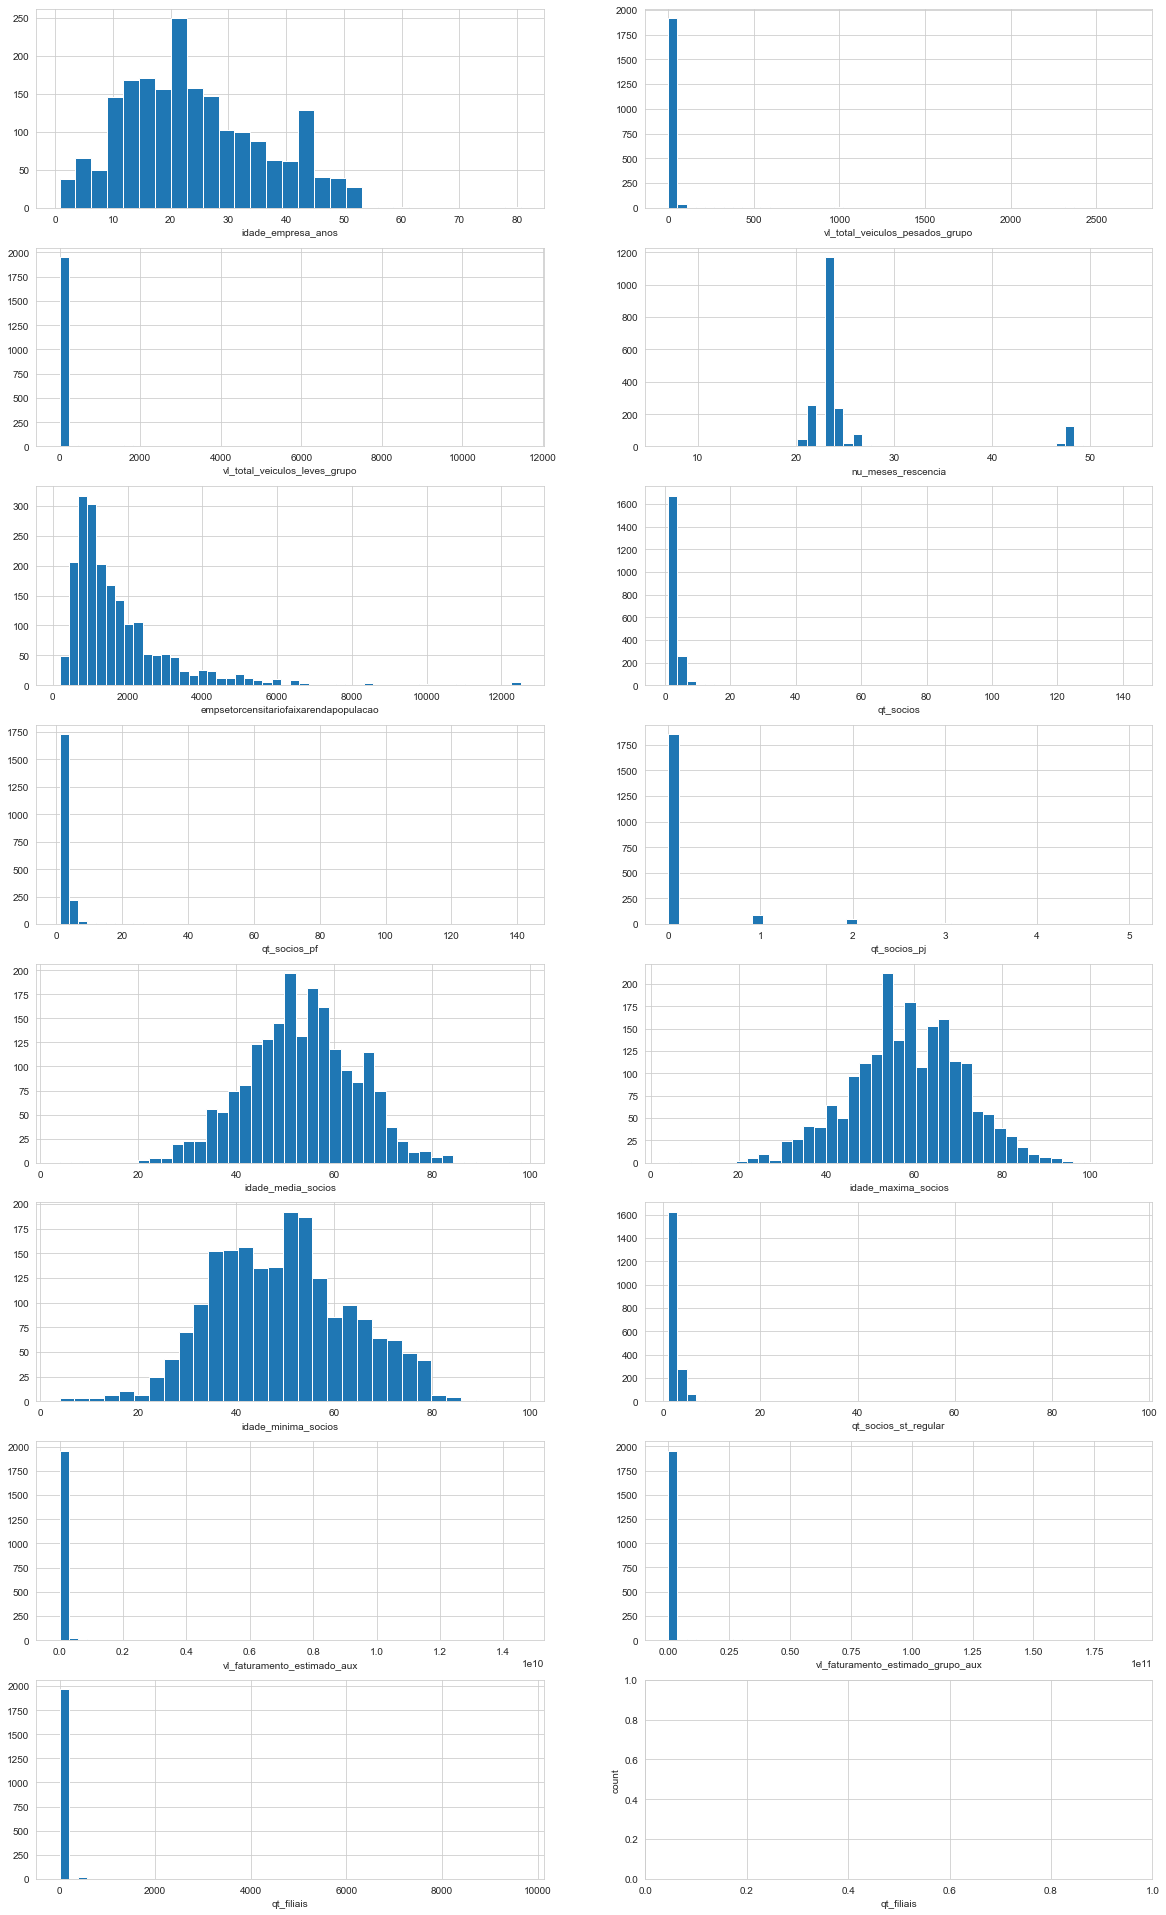

In [85]:
create_distplots(recommended_dataset, numeric_features)

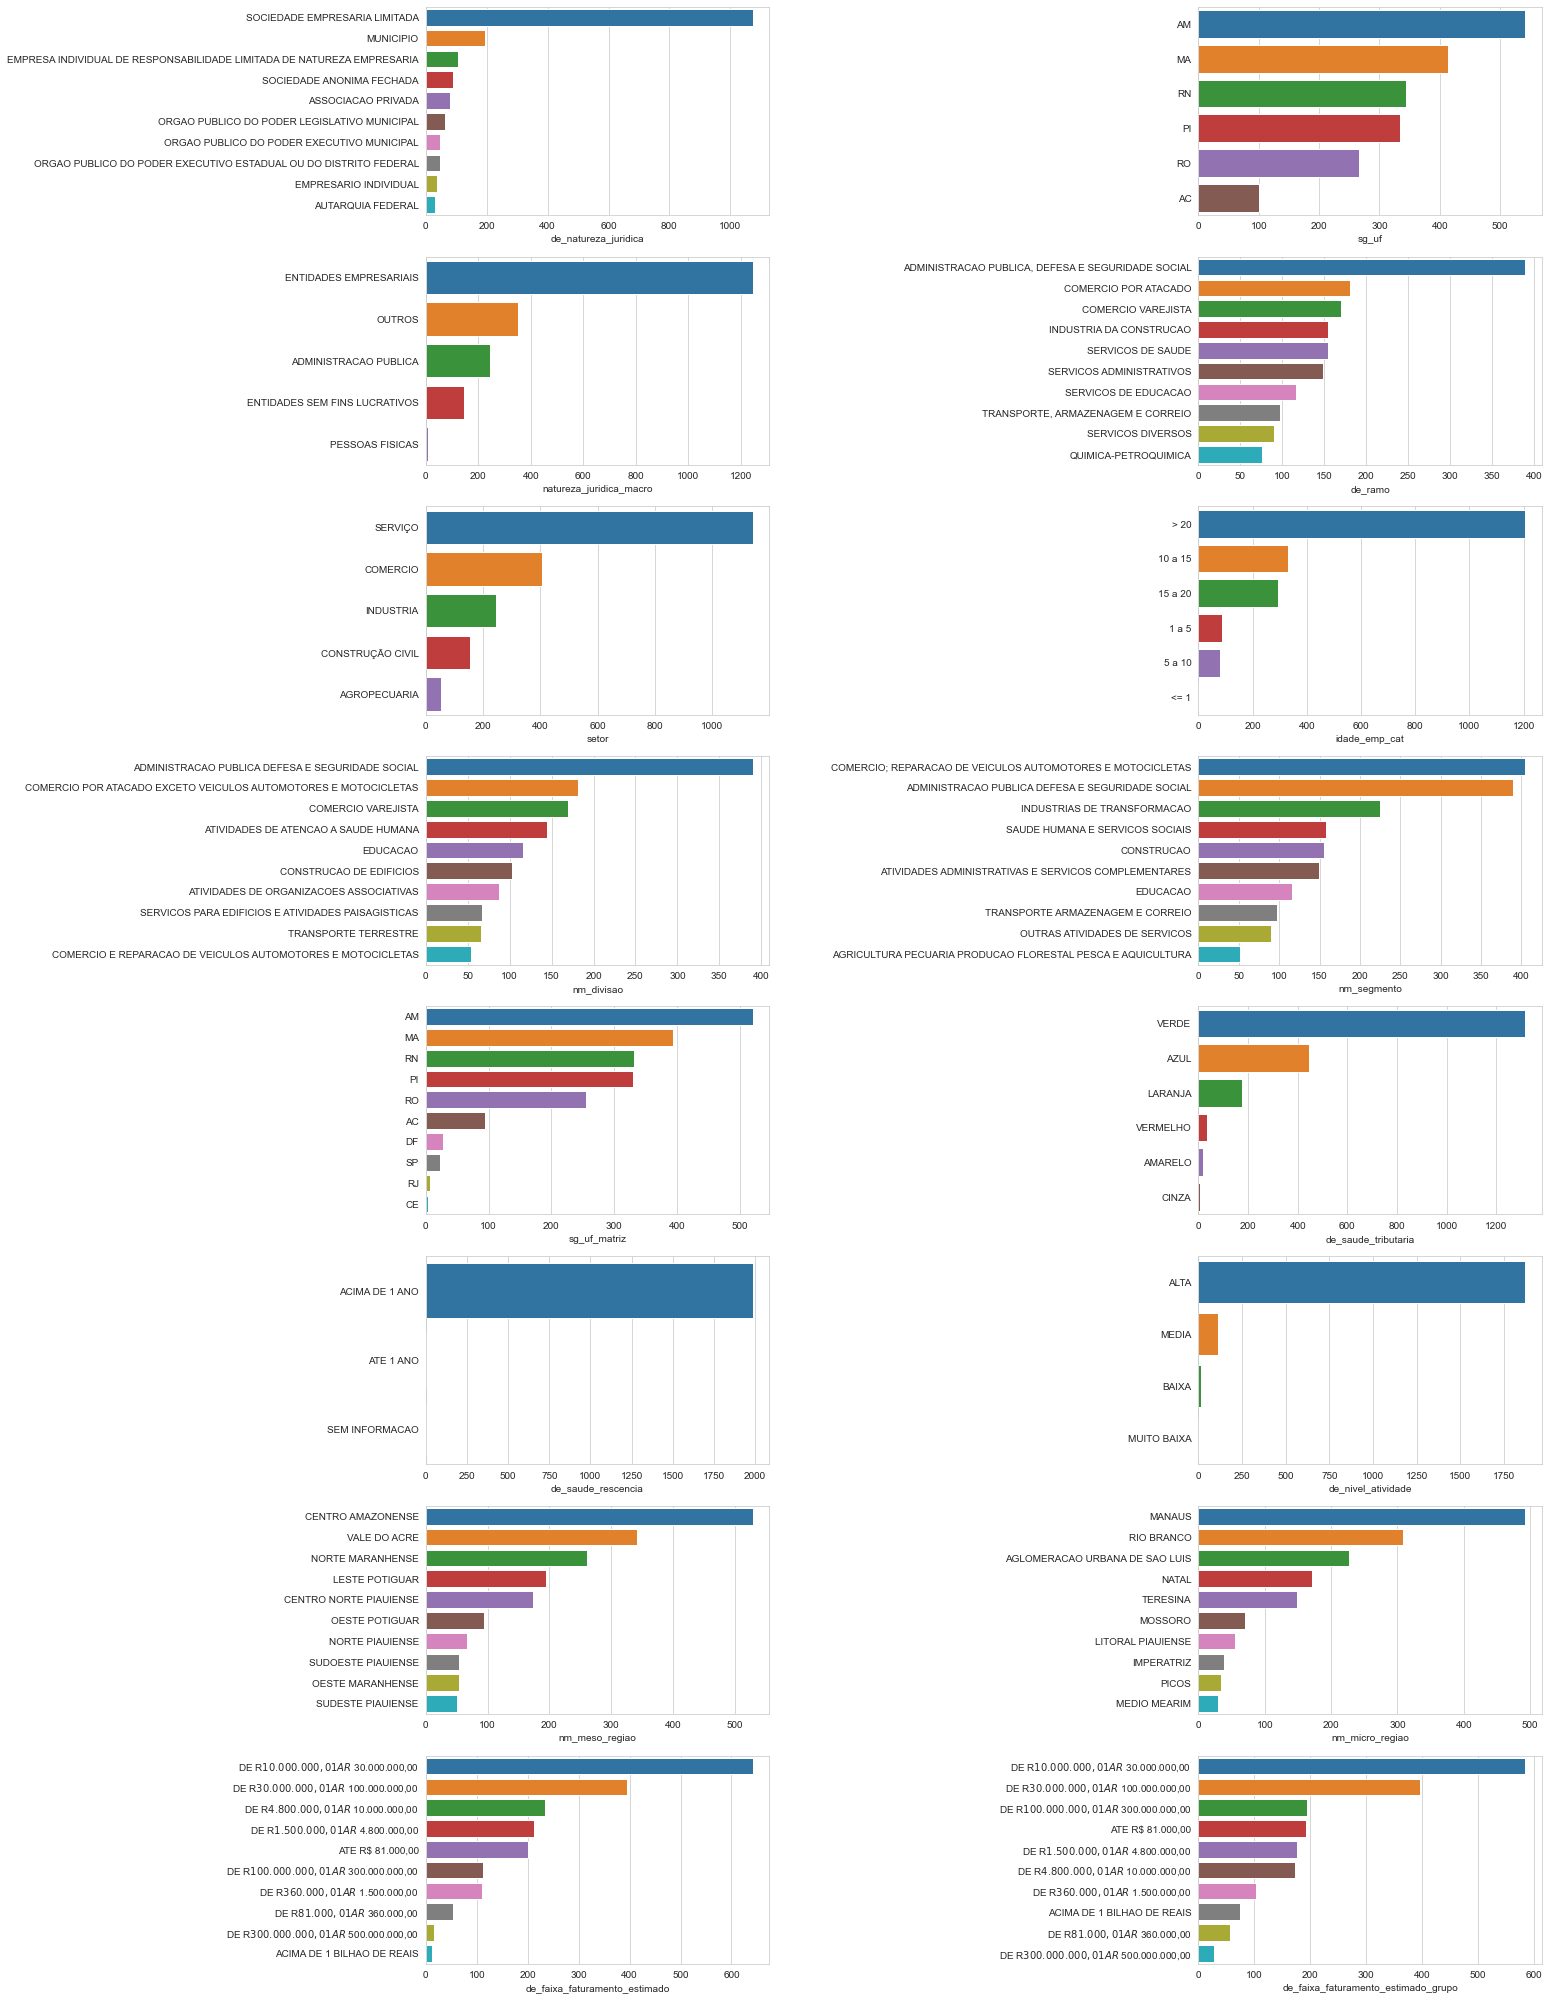

In [86]:
create_barplots(recommended_dataset, object_features, n_labels=10)

___
[go back to top](#top)  
___
## <a name="conclusion">7 Conclusion and Next Steps</a>
The main objective was to develop Leads for companies based on their portfolios, and it has been accomplished. The next step is to develop a web-app of sorts to automate this process, e.g. to turn it user friendly. This project taught me a lot, and it gives insights on how to use many machine learning techniques.  
The problem stated that new leads should be generated, so classic recommender systems were the first approach that came to mind. It was not until later in the project that fellow colleagues and students gave me insight on reframing the problem - hence, I ended up applying logistic regression, a simpler ML technique, in conjunction to what I already had in mind, to create this recommender system's skeleton! This also taught me that correctly framing your problem is very important at early stages of the project.  

In summary:  
* Sometimes (if not always) simpler is better!  
* The community - felow peers, colleagues, students - is VERY IMPORTANT to data students! Get mingled!  
* To someone that only has a hammer, every problem seems like a nail - sometimes, it's not a single technique or concept that'll do the trick, in this process i've used several to accomplish the end result.  
* I've never used this much data before, and I know for a fact that it's not even close to real life Biggest of Datas.

What could be better:  
* A better/more profound early analysis of the dataset could have spared me a lot of time and RAM. I still think that many of the features used in the training weren't as necessary.  
* The number of Principal Components used in the logistic regression training is still quite high!  
    * The last point is one of the reasons I did not present the analysis of portfolio 1 and 3, but feel free to try the code laid here!
* I'm feeling that the use of Object Oriented Programming would help me a lot in this project, and I intent to fill this gap.  
* Also, my notebook couldn't handle some of my experiments, so maybe I also should learn about cloud technologies (as noted in the fourth point just above).  

Next steps:  
* Create a web-app to turn this skeleton of a system into a user friendly platform.  
* Learn more about Object Oriented Programming.  
* Learn more about cloud techonologies.  

___
[go back to top](#top)  
___
## <a name="refs">8 References</a>

Most references are about classic recommender systems, which I actually did not use step by step, but the insights were very helpful.

[Simple Recommenders / Popularity Based System](https://www.datacamp.com/community/tutorials/recommender-systems-python)  
[Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)  
[Content Based Fitering](http://recommender-systems.org/content-based-filtering/)  
[Hybrid Methods](https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems)  
[The Data Science Process - Part 2](http://drunkendatascience.com/the-data-science-process-post-2-defining-the-project/)  
[MAP@K](http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html)  
[Metrics package](https://github.com/benhamner/Metrics)    
[Evaluation Metrics fo Recommender Systems](https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093)  
[Evaluating Recommender Systems](http://fastml.com/evaluating-recommender-systems/)  
[Mean Average Precision for Recommender Systems](http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html#Examples-and-Intuition-for-AP)  
[Recommender Systems in Python 101](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101#Evaluation)  
[Content Based Recommender](https://rpubs.com/tim-dim/recommender)  
[A Gentle Introduction to Recommender Systems](https://jessesw.com/Rec-System/)  
[Recommender Systems in Python - Part I: Content Based Filtering](https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831)  
[Recommender Systems in Practice](https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a)  
[Begginer Tutorial: Recommender Systems in Python](https://www.datacamp.com/community/tutorials/recommender-systems-python)  
[Build a Recommendation Engine with Collaborative Filtering](https://realpython.com/build-recommendation-engine-collaborative-filtering/#using-python-to-build-recommenders)  
[Dive into Deep Learning](http://d2l.ai/chapter_recommender-systems/index.html)  
[SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

___
### 9 THANK YOU FOR READING!   
Do you have any insights on how solve this differently or wish to know more?  
Message me @ [GitHub](https://github.com/Key0412) | [LinkedIn](https://www.linkedin.com/in/klismam-pereira/)
___
#### [Go back to top](#top)[, one more time](https://www.youtube.com/watch?v=FGBhQbmPwH8)
___